In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# import warnings
# warnings.filterwarnings(action="ignore")


In [2]:
df = pd.read_csv('data/Medicare_Provider_Utilization_and_Payment_Data__Part_D_Prescriber_Summary_Table_CY2017.csv')


In [3]:
df.shape

(1162898, 84)

In [4]:
# drop rows with missing values for the most important columns
# gets rid of all 4 brand / drug cols missing
# df = df.loc[(df['brand_claim_count'].notnull()) & (df['generic_claim_count'].notnull())] 
# the right way to do it 
df = df.dropna(subset=['brand_claim_count','generic_claim_count'], how='all')
df[['brand_claim_count','generic_claim_count']] = df[['brand_claim_count','generic_claim_count']].fillna(5)
df = df.dropna(subset=['brand_drug_cost','generic_drug_cost'])

# there are 72126 records that didnt prescribe any brand 
df_zero_brand_claim = df.loc[df['brand_claim_count']==0]
df = df.loc[df['brand_claim_count']!=0]

# drop cause not interesting. loses 22 columns
df = df.drop(['nppes_provider_street1', 'nppes_provider_street2',
       'nppes_provider_zip4', 'bene_count', 'description_flag', 'ge65_suppress_flag', 'bene_count_ge65_suppress_flag',
       'brand_suppress_flag', 'generic_suppress_flag', 'other_suppress_flag', 'other_claim_count',
       'other_drug_cost', 'mapd_suppress_flag','pdp_suppress_flag', 'lis_suppress_flag',
       'nonlis_suppress_flag','antipsych_ge65_suppress_flag',
       'antipsych_bene_ge65_suppress_flg', 'beneficiary_nondual_count',
       'beneficiary_dual_count'], axis=1)

total_cols = [col for col in df.columns if 'total_' in col]
df = df.drop(total_cols, axis=1)

# dropping cause not important samples. loses 732 rows
df = df[~df['nppes_provider_state'].isin (['XX', 'AA', 'AE', 'AP', 'AS', 'GU', 'MP', 'VI', 'ZZ'])]

# only a handful missing - easy to drop. loses 3
df = df.dropna(subset=['nppes_provider_gender', 'nppes_provider_zip5'])

# too many is missing (500k), dropping the whole col
df = df.drop('bene_count_ge65', axis=1)

# too many is missing (close to 1m) and there is a similar col 'average age' - dropping whole cols
df = df.drop(['beneficiary_age_less_65_count', 'beneficiary_age_65_74_count', 'beneficiary_age_75_84_count', 
              'beneficiary_age_greater_84_count'], axis=1)

# don't know what to do with them and they never showed up in feature importances - dropping whole cols
df = df.drop(['beneficiary_female_count', 'beneficiary_male_count', 'beneficiary_race_white_count', 
              'beneficiary_race_black_count', 'beneficiary_race_asian_pi_count', 'beneficiary_race_hispanic_count', 
              'beneficiary_race_nat_ind_count', 'beneficiary_race_other_count'], axis=1)

df = df.dropna(subset=['average_age_of_beneficiaries', 'beneficiary_average_risk_score'])

df['nppes_provider_zip5'] = df['nppes_provider_zip5'].astype(object)
# df['npi'] = df['npi'].astype(int)

In [5]:
df.shape

(540632, 43)

In [6]:
# df_one_hot.isin(['total_drug_cost'])
if 'total_drug_cost' in df.columns:
    print('yes')

In [7]:
# df.info()

# Brand / Generic

**1.a. TARGET 1: Continuous**

In [8]:
df['percent_prescribed_brand'] = df['brand_claim_count'] * 100.0 / (df['brand_claim_count'] + df['generic_claim_count'])
# there are 2 doctors with 0 brand_claim_count and 0 generic_claim_count resulting in NaN for percent_prescribe_brand
df[df[['percent_prescribed_brand', 'brand_claim_count','generic_claim_count']].isna().any(axis=1)]
# so i'm filling those 2 NaNs with 0
df['percent_prescribed_brand'] = df['percent_prescribed_brand'].fillna(0)

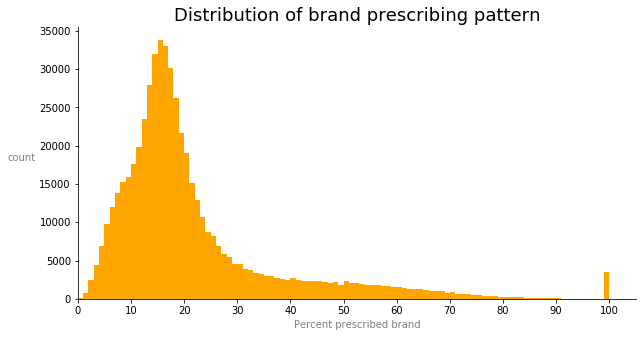

In [9]:
# DISTRIBUTION 1
plt.figure(figsize=(10, 5))
plt.hist(df['percent_prescribed_brand'].astype(int).sort_index(), bins=100, color='orange')
plt.xlabel('Percent prescribed brand', color='gray')
plt.ylabel('count', color='gray', rotation='horizontal', horizontalalignment='right')
plt.title('Distribution of brand prescribing pattern', fontsize=18)
plt.xlim(0, None)
plt.xticks(range(0, 101, 10))    
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False);

**1.b. TARGET 2: Binary**

In [10]:
df['prescribed_more_brand'] = np.where(df['brand_claim_count'] > df['generic_claim_count'], 1, 0)
df['prescribed_more_brand'].value_counts()

0    500440
1     40192
Name: prescribed_more_brand, dtype: int64

In [11]:
# distribution of target (skewed): If we were to always predict 0, we'd achieve an accuracy of %.
count_prescribed_more_generic = len(df[df["prescribed_more_brand"]==0]) 
count_prescribed_more_brand = len(df[df["prescribed_more_brand"]==1])
count_prescribed_only_brand = len(df[df["generic_claim_count"]==0])

percent_prescribed_more_generic = (count_prescribed_more_generic / (count_prescribed_more_generic + count_prescribed_more_brand )) * 100
percent_prescribed_more_brand = (count_prescribed_more_brand  / (count_prescribed_more_generic + count_prescribed_more_brand )) * 100
percent_prescribed_only_brand = (count_prescribed_only_brand  / (count_prescribed_more_generic + count_prescribed_more_brand )) * 100

percent_prescribed_only_brand, percent_prescribed_more_brand, percent_prescribed_more_generic

(0.6435061187647051, 7.434262122848814, 92.5657378771512)

In [12]:
df.groupby(df['prescribed_more_brand']).describe()

npi                                            \
                          count          mean           std           min   
prescribed_more_brand                                                       
0                      500440.0  1.499373e+09  2.879488e+08  1.003000e+09   
1                       40192.0  1.501676e+09  2.878596e+08  1.003001e+09   

                                                                               \
                                25%           50%           75%           max   
prescribed_more_brand                                                           
0                      1.245651e+09  1.497917e+09  1.740688e+09  1.993000e+09   
1                      1.255314e+09  1.508157e+09  1.750357e+09  1.992998e+09   

                      brand_claim_count                                      \
                                  count        mean         std   min   25%   
prescribed_more_brand                                                         
0                              500440.0  426.597200  798.551384  11.0  30.0   
1                               40192.0  556.297796  858.876754  11.0  63.0   

                                             brand_drug_cost                 \
                         50%    75%      max           count           mean   
prescribed_more_brand                                                         
0                      116.0  522.0  69081.0        500440.0  172779.036190   
1                      235.0  753.0  29927.0         40192.0  311598.224703   

                                                                     \
                                 std     min         25%        50%   
prescribed_more_brand                                                 
0                      366703.443020   15.48   6623.8925  46521.855   
1                      647219.486219  119.62  17460.6925  87211.965   

                                                generic_claim_count  \
                               75%          max               count   
prescribed_more_brand                                                 
0                      196685.3900  19375295.12            500440.0   
1                      343237.4925  26444676.02             40192.0   

                                                                             \
                              mean          std   min    25%    50%     75%   
prescribed_more_brand                                                         
0                      2025.148737  3513.902974  11.0  188.0  578.0  2473.0   
1                       353.133982   568.413650   0.0   35.0  138.0   453.0   

                                generic_drug_cost                              \
                            max             count          mean           std   
prescribed_more_brand                                                           
0                      375762.0          500440.0  51814.274693  85585.489512   
1                       17501.0           40192.0  11057.744981  20871.132658   

                                                                           \
                         min       25%        50%         75%         max   
prescribed_more_brand                                                       
0                      50.53  3949.165  17409.505  67043.6675  5151671.13   
1                       0.00   869.910   3771.460  13103.3325   508957.88   

                      mapd_claim_count                                       \
                                 count         mean          std  min   25%   
prescribed_more_brand                                                         
0                             473211.0  1002.118042  2068.378590  0.0  69.0   
1                              34024.0   386.051052   756.540253  0.0  46.0   

                                               mapd_drug_cost                \
                         50%     75%       max          count        

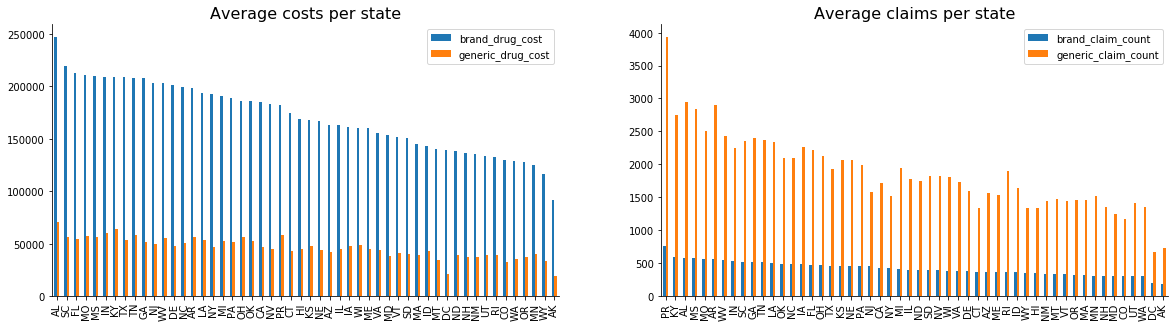

In [13]:
# IT SHOWS THAT drug costs are always higher for brand, but claim counts are always higher for generic
# create 1 overall figure with 2x2 Axes Subplots nested inside of it
fig, axarr = plt.subplots(1, 2, figsize=(20, 5))
# tell pandas which subplot news plots to go in
df[['brand_drug_cost', 'generic_drug_cost']].groupby(df['nppes_provider_state']).mean().sort_values(by='brand_drug_cost', ascending=False).plot(kind='bar', ax=axarr[0]);
axarr[0].set_title("Average costs per state", fontsize=16)
axarr[0].set_xlabel("")
df[['brand_claim_count', 'generic_claim_count']].groupby(df['nppes_provider_state']).mean().sort_values(by='brand_claim_count', ascending=False).plot(kind='bar', ax=axarr[1]);
axarr[1].set_title("Average claims per state", fontsize=16)
axarr[1].set_xlabel("")
plt.subplots_adjust(hspace=.3)
sns.despine()

**2. Feature Engineering for Brand / Generic** 

In [14]:
df['brand_cost_per_claim'] = df['brand_drug_cost'] / df['brand_claim_count']
df['generic_cost_per_claim'] = df['generic_drug_cost'] / df['generic_claim_count']

df['brand_cost_per_claim'].fillna(0, inplace=True)
df['generic_cost_per_claim'].fillna(0, inplace=True)

Average cost per claim, whether generic or brand, is always higher with doctors who prescribe more brand.

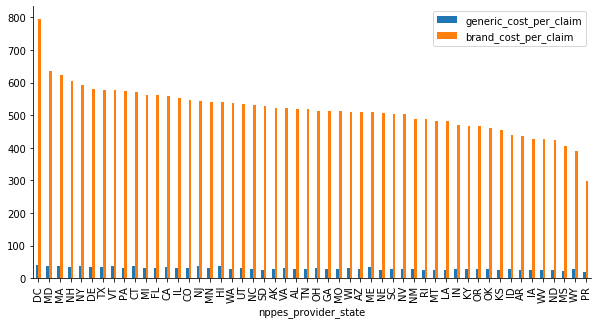

In [15]:
df[['generic_cost_per_claim','brand_cost_per_claim']].groupby(df['nppes_provider_state']).mean().sort_values(by='brand_cost_per_claim', ascending=False).plot(kind='bar', figsize=(10,5));
sns.despine();

In [16]:
df['brand_cost_per_claim'].mean() / df['generic_cost_per_claim'].mean()


17.20630124718711

EVERY state's brand cost per claim is on average 17 times higher than generic cost per claim..

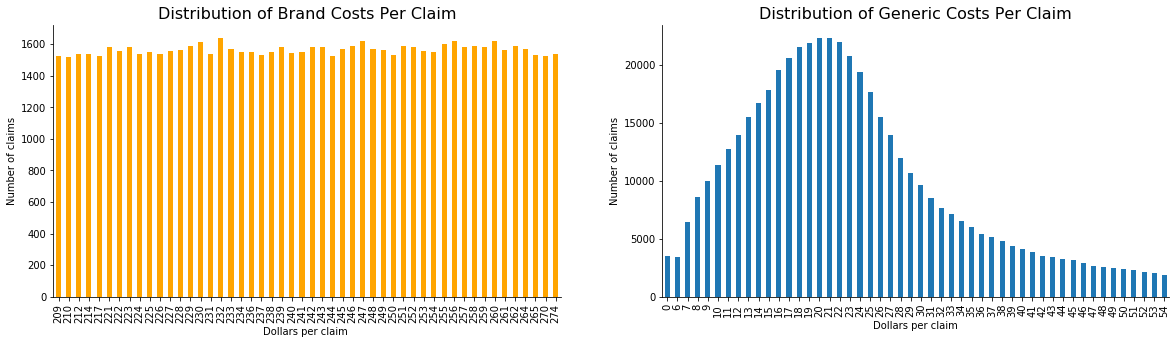

In [17]:
brand_cpc_counts = df['brand_cost_per_claim'].astype(int).value_counts()
generic_cpc_counts = df['generic_cost_per_claim'].astype(int).value_counts()

fig, axarr = plt.subplots(1, 2, figsize=(20, 5))

# axarr[0].bar(brand_cpc_counts[:50].index, brand_cpc_counts[:50].values, label='Brand');
# axarr[0].hist(df['brand_cost_per_claim'].astype(int))#1 bar
brand_cpc_counts[:50].sort_index().plot(kind='bar', ax=axarr[0],color='orange')
# axarr[0].legend()
axarr[0].set_title("Distribution of Brand Costs Per Claim", fontsize=16)
axarr[0].set_ylabel("Number of claims")
axarr[0].set_xlabel("Dollars per claim ")

# axarr[1].bar(generic_cpc_counts[:50].index, generic_cpc_counts[:50].values, label='Generic');
# axarr[1].hist(df['generic_cost_per_claim'].astype(int)) #1 bar
generic_cpc_counts[:50].sort_index().plot(kind='bar', ax=axarr[1])

# axarr[1].legend()
axarr[1].set_title("Distribution of Generic Costs Per Claim", fontsize=16)
axarr[1].set_ylabel("Number of claims")
axarr[1].set_xlabel("Dollars per claim")

plt.subplots_adjust(hspace=.1)
sns.despine()

In [18]:
df['brand_cost_per_claim'].median(), df['generic_cost_per_claim'].median()

(266.3808984489283, 22.949241719139053)

In [19]:
df['brand_cost_per_claim'].std(), df['generic_cost_per_claim'].std()

(1135.2555514680516, 47.137359610000225)

The distribution of the generic cost per claim is right skewed, while the distribution of the generic cost per claim is roughly uniformly distributed, meaning the probability of each event is the same.

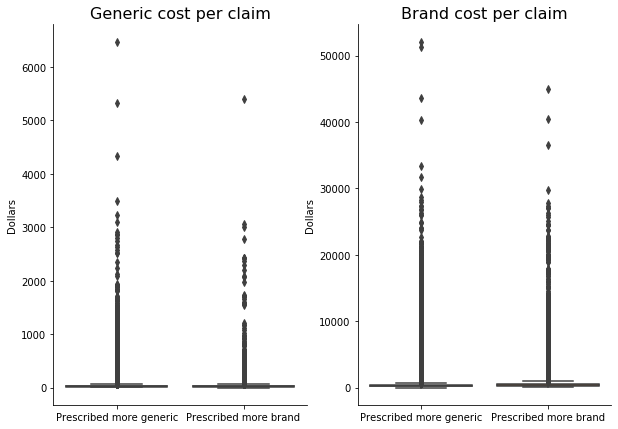

In [20]:
# normal practice cost per claim - not interesting, but good for grabbing outliers

# # create 1 overall figure with 2x2 Axes Subplots nested inside of it
fig, axarr = plt.subplots(1, 2, figsize=(10, 7))
# fig.suptitle("Distributions of cost per claim proportions per prescription pattern", fontsize=18)
# # tell pandas which subplot news plots to go in
sns.boxplot(x='prescribed_more_brand', y='generic_cost_per_claim', data=df, ax=axarr[0]);
axarr[0].set_title("Generic cost per claim", fontsize=16)
axarr[0].set_ylabel("Dollars")
axarr[0].set_xlabel("")
axarr[0].set_xticklabels(['Prescribed more generic', 'Prescribed more brand'])
sns.boxplot(x='prescribed_more_brand', y='brand_cost_per_claim', data=df, ax=axarr[1]);
axarr[1].set_title("Brand cost per claim", fontsize=16)
axarr[1].set_ylabel("Dollars")
axarr[1].set_xlabel("")
axarr[1].set_xticklabels(['Prescribed more generic', 'Prescribed more brand'])
plt.subplots_adjust(hspace=.9)
sns.despine()

**Interpretation:** the majority of data centers around zero, this is mostly useful to detect outliers. 

In [21]:
# OUTLIER ADD N1
# outliers = df.iloc[0,0]
outliers = df.loc[(df['generic_cost_per_claim']>4000) | (df['brand_cost_per_claim']>30000)] # adds 12
outliers['reason'] = np.where((outliers['generic_cost_per_claim']>30000) | (outliers['brand_cost_per_claim']>30000), 'brand/generic', 'brand/generic')
outliers.shape


/Users/Olga/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(13, 48)

**Average prescription per state**

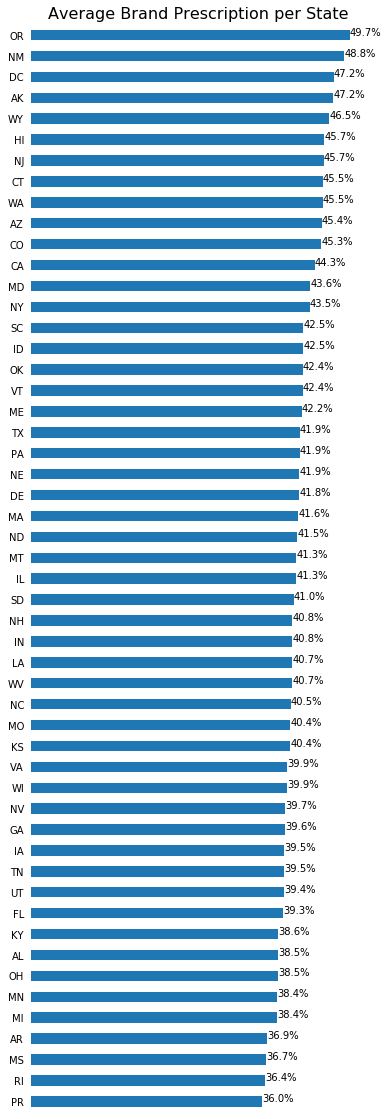

In [22]:
# Average prescription per state
plt.figure(figsize=(6,20))

ax = df['percent_prescribed_brand'].groupby(df['nppes_provider_state']).mean().sort_values(ascending=True).plot(kind='barh')

plt.title("Average Brand Prescription per State", fontsize= 16)
plt.ylabel('')
plt.xticks([])

# Despine
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# switch off ticks 
ax.tick_params(left=False, labelleft=True)

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Add percentages
total = len(df['percent_prescribed_brand'].groupby(df['nppes_provider_state']).mean())
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
plt.show()

**Average prescription per specialty**

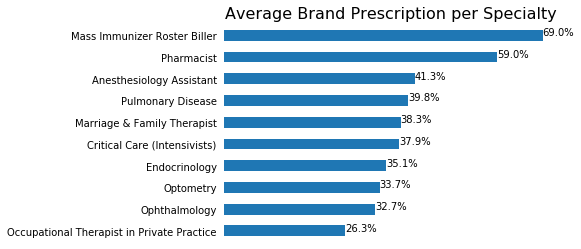

In [23]:
# Average prescription per specialty

plt.figure()

ax = df['percent_prescribed_brand'].groupby(df['specialty_description']).mean().sort_values(ascending=True).tail(10).plot(kind='barh', width=0.5)

plt.title("Average Brand Prescription per Specialty", fontsize= 16)
plt.xticks([])
plt.ylabel('')
plt.xticks([])

ax.tick_params(left=False, labelleft=True)
           
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False);
plt.gca().spines['right'].set_visible(False);
ax.spines['left'].set_visible(False)

total = len(df['percent_prescribed_brand'].groupby(df['specialty_description']).mean())
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
        
plt.show()

# Disorders

opioid_prescriber_rate is the percent of the total_claim_count represented by the opioid_claim_count. 

la_opioid_prescriber_rate is the percent of the opioid_claim_count represented by the la_opioid_claim_count.

In [24]:
disorder = df[['opioid_claim_count', 'opioid_drug_cost', 'opioid_bene_count',
               'opioid_day_supply', 'opioid_prescriber_rate',
               'la_opioid_claim_count', 'la_opioid_drug_cost', 'la_opioid_bene_count',
               'la_opioid_day_supply', 'la_opioid_prescriber_rate',
               'antibiotic_claim_count', 'antibiotic_drug_cost', 'antibiotic_bene_count',
               'antipsych_claim_count_ge65', 'antipsych_drug_cost_ge65', 'antipsych_bene_count_ge65']]

In [25]:
disorder.groupby(df['prescribed_more_brand']).describe()

opioid_claim_count                                    \
                                   count        mean         std  min  25%   
prescribed_more_brand                                                        
0                               390779.0  151.316404  395.356397  0.0  0.0   
1                                30343.0    2.221600   20.985464  0.0  0.0   

                                            opioid_drug_cost               \
                        50%    75%      max            count         mean   
prescribed_more_brand                                                       
0                      36.0  141.0  20599.0         390779.0  7172.182195   
1                       0.0    0.0   2036.0          30343.0   123.458871   

                                                                             \
                                std  min  25%     50%       75%         max   
prescribed_more_brand                                                         
0                      35600.488152  0.0  0.0  362.05  3313.775  4009491.50   
1                       4090.915305  0.0  0.0    0.00     0.000   461919.71   

                      opioid_bene_count                                        \
                                  count       mean        std  min  25%   50%   
prescribed_more_brand                                                           
0                              363132.0  42.495035  69.071869  0.0  0.0  23.0   
1                               29372.0   0.904263   7.012139  0.0  0.0   0.0   

                                    opioid_day_supply               \
                        75%     max             count         mean   
prescribed_more_brand                                                
0                      56.0  2244.0          390779.0  3614.526671   
1                       0.0   380.0           30343.0    40.002669   

                                                                        \
                                std  min  25%    50%     75%       max   
prescribed_more_brand                                                    
0                      10979.639772  0.0  0.0  391.0  2993.0  615456.0   
1                        554.938143  0.0  0.0    0.0     0.0   59661.0   

                      opioid_prescriber_rate                                 \
                                       count      mean        std  min  25%   
prescribed_more_brand                                                         
0                                   390779.0  8.146984  13.738133  0.0  0.0   
1                                    30343.0  0.286991   2.237107  0.0  0.0   

                                         la_opioid_claim_count             \
                        50%   75%    max                 count       mean   
prescribed_more_brand                                                       
0                      2.96  8.42  100.0              421646.0  17.948011   
1                      0.00  0.00   84.0               38899.0   0.181059   

                                                              \
                             std  min  25%  50%  75%     max   
prescribed_more_brand                                          
0                      92.961841  0.0  0.0  0.0  0.0  5570.0   
1                       6.594956  0.0  0.0  0.0  0.0   997.0   

                      la_opioid_drug_cost                                  \
                                    count         mean           std  min   
prescribed_more_brand                                                       
0                                421646.0  3525.852465  22567.895809  0.0   
1                                 38899.0    51.263136   2719.450570  0.0   

                                                 la_opioid_bene_count  \
                       25%  50%  75%         max                count   
prescribed_more_brand                                                   
0            

### Feature engineering on disorders

In [26]:
df['opioid_claim_per_bene'] = df['opioid_claim_count'] / df['opioid_bene_count']
df['opioid_cost_per_bene'] = df['opioid_drug_cost'] / df['opioid_bene_count']
df['opioid_cost_per_claim'] = df['opioid_drug_cost'] / df['opioid_claim_count']

df['la_opioid_claim_per_bene'] = df['la_opioid_claim_count'] / df['la_opioid_bene_count']
df['la_opioid_cost_per_bene'] = df['la_opioid_drug_cost'] /  df['la_opioid_bene_count']
df['la_opioid_cost_per_claim'] = df['la_opioid_drug_cost'] / df['la_opioid_claim_count']

df['antibiotic_claim_per_bene'] = df['antibiotic_claim_count'] / df['antibiotic_bene_count']
df['antibiotic_cost_per_bene'] = df['antibiotic_drug_cost'] / df['antibiotic_bene_count']
df['antibiotic_cost_per_claim'] = df['antibiotic_drug_cost'] / df['antibiotic_claim_count']

df['antipsych_claim_per_bene_ge65'] = df['antipsych_claim_count_ge65'] / df['antipsych_bene_count_ge65']
df['antipsych_cost_per_bene_ge65'] = df['antipsych_drug_cost_ge65'] /  df['antipsych_bene_count_ge65']
df['antipsych_cost_per_claim_ge65'] = df['antipsych_drug_cost_ge65'] / df['antipsych_claim_count_ge65']

# fillna(0) cause dividing 0 by 0 results is NaN
df['opioid_claim_per_bene'].fillna(0, inplace=True)
df['opioid_cost_per_bene'].fillna(0, inplace=True)
df['opioid_cost_per_claim'].fillna(0, inplace=True)

df['la_opioid_claim_per_bene'].fillna(0, inplace=True)
df['la_opioid_cost_per_bene'].fillna(0, inplace=True)
df['la_opioid_cost_per_claim'].fillna(0, inplace=True)

df['antibiotic_claim_per_bene'].fillna(0, inplace=True)
df['antibiotic_cost_per_bene'].fillna(0, inplace=True)
df['antibiotic_cost_per_claim'].fillna(0, inplace=True)

df['antipsych_claim_per_bene_ge65'].fillna(0, inplace=True)
df['antipsych_cost_per_bene_ge65'].fillna(0, inplace=True)
df['antipsych_cost_per_claim_ge65'].fillna(0, inplace=True)

claims_per_bene = df[['opioid_claim_per_bene', 'la_opioid_claim_per_bene', 
                      'antibiotic_claim_per_bene', 'antipsych_claim_per_bene_ge65']]

costs_per_bene = df[['opioid_cost_per_bene', 'la_opioid_cost_per_bene', 
                    'antibiotic_cost_per_bene', 'antipsych_cost_per_bene_ge65']]

costs_per_claim = df[['opioid_cost_per_claim', 'la_opioid_cost_per_claim', 
                    'antibiotic_cost_per_claim', 'antipsych_cost_per_claim_ge65']]

opioid_engineered = df[['opioid_claim_per_bene', 'opioid_cost_per_bene', 'opioid_cost_per_claim']]
la_opioid_engineered = df[['la_opioid_claim_per_bene', 'la_opioid_cost_per_bene', 'la_opioid_cost_per_claim']]
antibiotic_engineered = df[['antibiotic_claim_per_bene', 'antibiotic_cost_per_bene', 'antibiotic_cost_per_claim']]
antipsych_engineered = df[['antipsych_claim_per_bene_ge65', 'antipsych_cost_per_bene_ge65','antipsych_cost_per_claim_ge65']]

# df[['opioid_claim_per_bene', 'opioid_cost_per_bene', 'opioid_claim_count', 'opioid_drug_cost', 'opioid_bene_count']].sort_values(by='opioid_claim_per_bene').head()

**1.Opioids engineered**

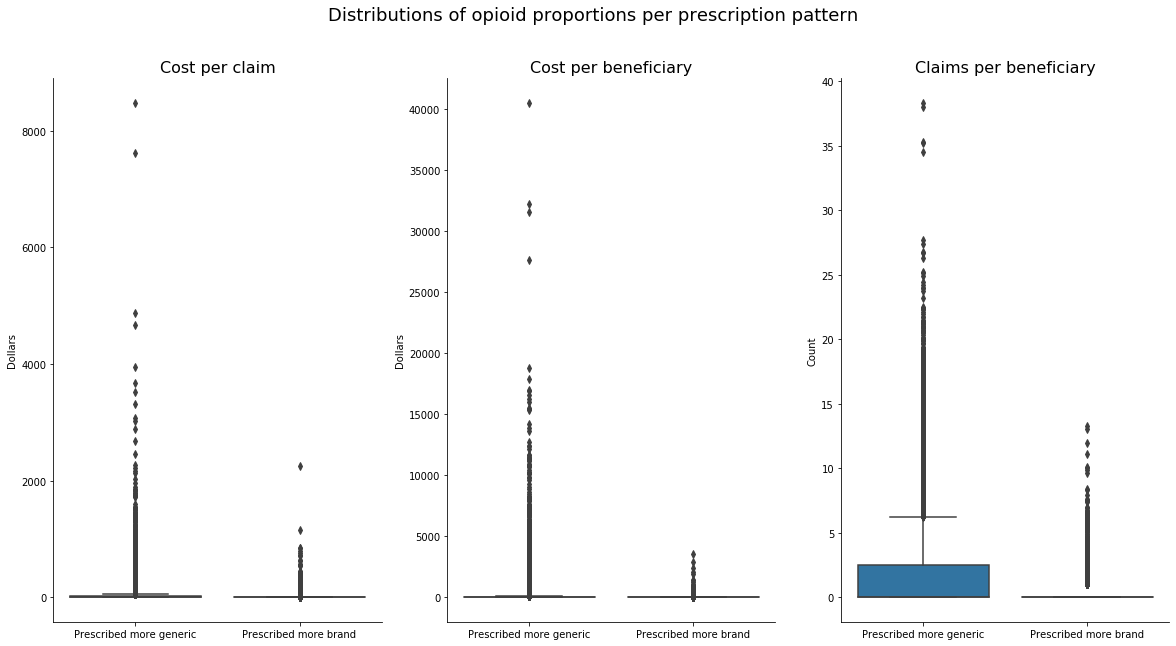

In [27]:
# # create 1 overall figure with 2x2 Axes Subplots nested inside of it
fig, axarr = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle("Distributions of opioid proportions per prescription pattern", fontsize=18)

# # tell pandas which subplot news plots to go in
sns.boxplot(x='prescribed_more_brand', y='opioid_cost_per_claim', data=df, ax=axarr[0]);
axarr[0].set_title("Cost per claim", fontsize=16)
axarr[0].set_ylabel("Dollars")
axarr[0].set_xlabel("")
axarr[0].set_xticklabels(['Prescribed more generic', 'Prescribed more brand'])

sns.boxplot(x='prescribed_more_brand', y='opioid_cost_per_bene', data=df, ax=axarr[1]);
axarr[1].set_title("Cost per beneficiary", fontsize=16)
axarr[1].set_ylabel("Dollars")
axarr[1].set_xlabel("")
axarr[1].set_xticklabels(['Prescribed more generic', 'Prescribed more brand'])

sns.boxplot(x='prescribed_more_brand', y='opioid_claim_per_bene', data=df, ax=axarr[2]);
axarr[2].set_title("Claims per beneficiary", fontsize=16)
axarr[2].set_ylabel("Count")
axarr[2].set_xlabel("")
axarr[2].set_xticklabels(['Prescribed more generic', 'Prescribed more brand'])

plt.subplots_adjust(hspace=.9)
sns.despine()

In [28]:
# OUTLIER ADD N2
outliers = outliers.append(df[df['opioid_cost_per_claim']>3000])
outliers = outliers.append(df[df['opioid_cost_per_bene']>15000]) 
outliers = outliers.append(df[df['opioid_claim_per_bene']>25])

outliers.loc[outliers['reason'].isnull(), 'reason'] = 'opioid'

outliers.shape

/Users/Olga/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(49, 60)

**2. Long-acting opioids engineered**

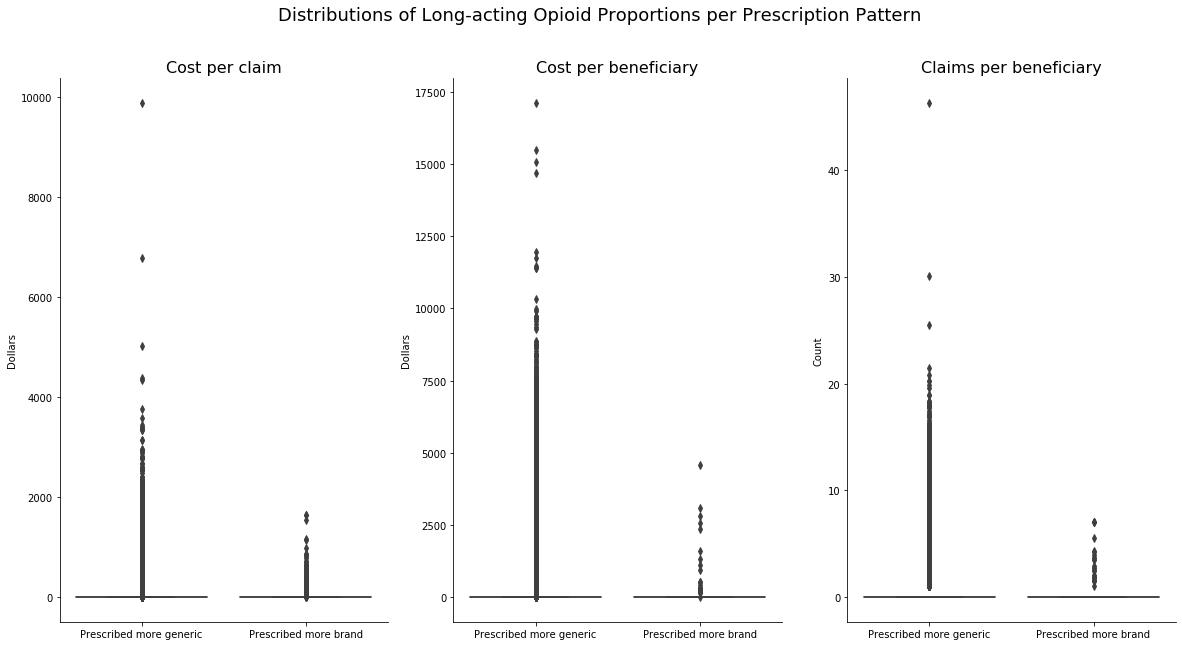

In [29]:
# # create 1 overall figure with 2x2 Axes Subplots nested inside of it
fig, axarr = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle("Distributions of Long-acting Opioid Proportions per Prescription Pattern", fontsize=18)

# # tell pandas which subplot news plots to go in
sns.boxplot(x='prescribed_more_brand', y='la_opioid_cost_per_claim', data=df, ax=axarr[0]);
axarr[0].set_title("Cost per claim", fontsize=16)
axarr[0].set_ylabel("Dollars")
axarr[0].set_xlabel("")
axarr[0].set_xticklabels(['Prescribed more generic', 'Prescribed more brand'])

sns.boxplot(x='prescribed_more_brand', y='la_opioid_cost_per_bene', data=df, ax=axarr[1]);
axarr[1].set_title("Cost per beneficiary", fontsize=16)
axarr[1].set_ylabel("Dollars")
axarr[1].set_xlabel("")
axarr[1].set_xticklabels(['Prescribed more generic', 'Prescribed more brand'])

sns.boxplot(x='prescribed_more_brand', y='la_opioid_claim_per_bene', data=df, ax=axarr[2]);
axarr[2].set_title("Claims per beneficiary", fontsize=16)
axarr[2].set_ylabel("Count")
axarr[2].set_xlabel("")
axarr[2].set_xticklabels(['Prescribed more generic', 'Prescribed more brand'])

plt.subplots_adjust(hspace=.9)
sns.despine()

In [30]:
# OUTLIER ADD N3
outliers = outliers.append(df[df['la_opioid_cost_per_claim']>4000]) # adds 2
outliers = outliers.append(df[df['la_opioid_cost_per_bene']>10000]) # adds 4
outliers = outliers.append(df[df['la_opioid_claim_per_bene']>20]) # adds 3

outliers.loc[outliers['reason'].isnull(), 'reason'] = 'la_opioid'

outliers.shape

/Users/Olga/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(71, 60)

**3. Antibiotic engineered**

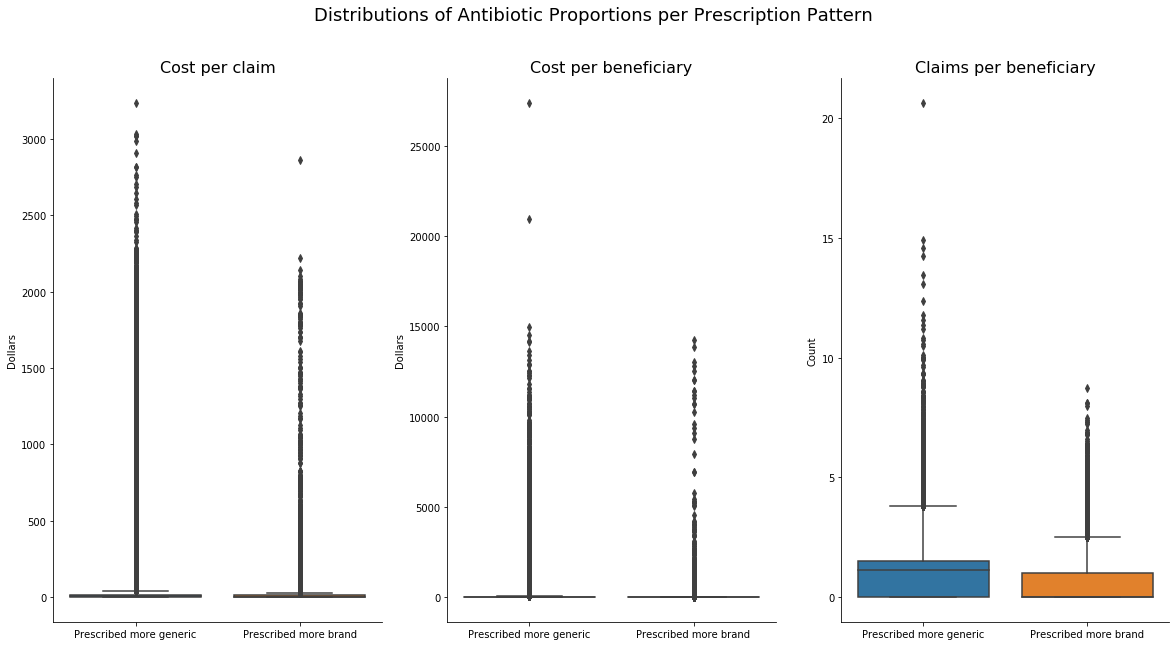

In [31]:
# # create 1 overall figure with 2x2 Axes Subplots nested inside of it
fig, axarr = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle("Distributions of Antibiotic Proportions per Prescription Pattern", fontsize=18)

# # tell pandas which subplot news plots to go in
sns.boxplot(x='prescribed_more_brand', y='antibiotic_cost_per_claim', data=df, ax=axarr[0]);
axarr[0].set_title("Cost per claim", fontsize=16)
axarr[0].set_ylabel("Dollars")
axarr[0].set_xlabel("")
axarr[0].set_xticklabels(['Prescribed more generic', 'Prescribed more brand'])

sns.boxplot(x='prescribed_more_brand', y='antibiotic_cost_per_bene', data=df, ax=axarr[1]);
axarr[1].set_title("Cost per beneficiary", fontsize=16)
axarr[1].set_ylabel("Dollars")
axarr[1].set_xlabel("")
axarr[1].set_xticklabels(['Prescribed more generic', 'Prescribed more brand'])

sns.boxplot(x='prescribed_more_brand', y='antibiotic_claim_per_bene', data=df, ax=axarr[2]);
axarr[2].set_title("Claims per beneficiary", fontsize=16)
axarr[2].set_ylabel("Count")
axarr[2].set_xlabel("")
axarr[2].set_xticklabels(['Prescribed more generic', 'Prescribed more brand'])

plt.subplots_adjust(hspace=.9)
sns.despine()

In [32]:
# OUTLIER ADD N4
outliers = outliers.append(df[df['antibiotic_cost_per_claim']>2500])
outliers = outliers.append(df[df['antibiotic_cost_per_bene']>15000]) 
outliers = outliers.append(df[df['antibiotic_claim_per_bene']>13])

outliers.loc[outliers['reason'].isnull(), 'reason'] = 'antibiotic'

outliers.shape

/Users/Olga/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(97, 60)

**4. Antipsych engineered**

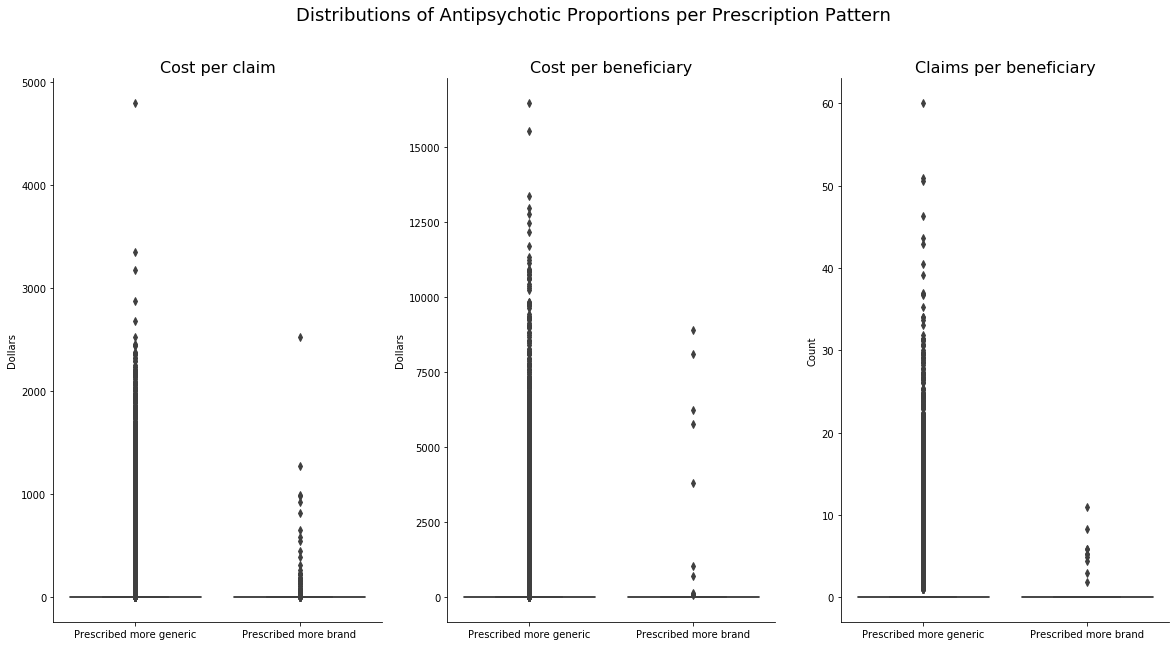

In [33]:
# # create 1 overall figure with 2x2 Axes Subplots nested inside of it
fig, axarr = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle("Distributions of Antipsychotic Proportions per Prescription Pattern", fontsize=18)

# # tell pandas which subplot news plots to go in
sns.boxplot(x='prescribed_more_brand', y='antipsych_cost_per_claim_ge65', data=df, ax=axarr[0]);
axarr[0].set_title("Cost per claim", fontsize=16)
axarr[0].set_ylabel("Dollars")
axarr[0].set_xlabel("")
axarr[0].set_xticklabels(['Prescribed more generic', 'Prescribed more brand'])

sns.boxplot(x='prescribed_more_brand', y='antipsych_cost_per_bene_ge65', data=df, ax=axarr[1]);
axarr[1].set_title("Cost per beneficiary", fontsize=16)
axarr[1].set_ylabel("Dollars")
axarr[1].set_xlabel("")
axarr[1].set_xticklabels(['Prescribed more generic', 'Prescribed more brand'])

sns.boxplot(x='prescribed_more_brand', y='antipsych_claim_per_bene_ge65', data=df, ax=axarr[2]);
axarr[2].set_title("Claims per beneficiary", fontsize=16)
axarr[2].set_ylabel("Count")
axarr[2].set_xlabel("")
axarr[2].set_xticklabels(['Prescribed more generic', 'Prescribed more brand'])

plt.subplots_adjust(hspace=.9)
sns.despine()

In [34]:
# OUTLIER ADD N5
outliers = outliers.append(df[df['antipsych_cost_per_claim_ge65']>2500]) # adds 3
outliers = outliers.append(df[df['antipsych_cost_per_bene_ge65']>12500]) # adds 4
outliers = outliers.append(df[df['antipsych_claim_per_bene_ge65']>40]) # adds 5

outliers.loc[outliers['reason'].isnull(), 'reason'] = 'antipsych'

outliers.shape

/Users/Olga/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(116, 60)

# Demographics

**1.Income**

In [35]:
df['lis_cost_per_claim'] = df['lis_drug_cost'] / df['lis_claim_count']
df['nonlis_cost_per_claim'] = df['nonlis_drug_cost'] / df['nonlis_claim_count']

df['lis_cost_per_claim'].fillna(0, inplace=True)
df['nonlis_cost_per_claim'].fillna(0, inplace=True)

In [36]:
income = df[['lis_cost_per_claim', 'nonlis_cost_per_claim', 'lis_claim_count', 'nonlis_claim_count', 'lis_drug_cost', 'nonlis_drug_cost']]
income.groupby(df['prescribed_more_brand']).describe()

lis_cost_per_claim                                \
                                   count        mean          std  min   
prescribed_more_brand                                                    
0                               500440.0  152.457930   423.032440  0.0   
1                                40192.0  360.874185  1037.222438  0.0   

                                                                        \
                             25%         50%         75%           max   
prescribed_more_brand                                                    
0                      37.928399   67.586014  108.698091  31271.955455   
1                      88.133168  189.584214  327.168334  38745.381250   

                      nonlis_cost_per_claim                               \
                                      count        mean         std  min   
prescribed_more_brand                                                      
0                                  500440.0  109.103790  302.038291  0.0   
1                                   40192.0  312.355954  832.092490  0.0   

                                                                        \
                             25%         50%         75%           max   
prescribed_more_brand                                                    
0                      29.778955   51.424416   82.929095  33519.497105   
1                      89.900675  172.235591  296.796409  31220.713281   

                      lis_claim_count                                       \
                                count         mean          std  min   25%   
prescribed_more_brand                                                        
0                            476279.0  1130.630061  2827.530936  0.0  77.0   
1                             33567.0   408.776119   865.992505  0.0  52.0   

                                               nonlis_claim_count  \
                         50%     75%       max              count   
prescribed_more_brand                                               
0                      252.0  1073.0  432287.0           476279.0   
1                      166.0   457.5   37967.0            33567.0   

                                                                            \
                              mean          std  min    25%    50%     75%   
prescribed_more_brand                                                        
0                      1453.711598  2441.882425  0.0  125.0  389.0  1674.0   
1                       699.113117   959.170341  0.0   96.0  338.0   950.0   

                               lis_drug_cost                                \
                           max         count           mean            std   
prescribed_more_brand                                                        
0                      72312.0      476279.0  116064.643154  276774.327705   
1                      14615.0       33567.0  167053.609665  415640.300306   

                                                                         \
                       min       25%       50%         75%          max   
prescribed_more_brand                                                     
0                      0.0  4025.705  25703.43  114820.950  15390721.93   
1                      0.0  9952.930  40812.11  152878.445  19625039.71   

                      nonlis_drug_cost                                     \
                                 count           mean            std  min   
prescribed_more_brand                                                       
0                             476279.0  119336.313902  241629.956673  0.0   
1                              33567.0  216528.439390  403133.258853  0.0   

                                                                    
                            25%       50%         75%          max  
prescribed_more_brand                                               
0                       5232.81  27200.6

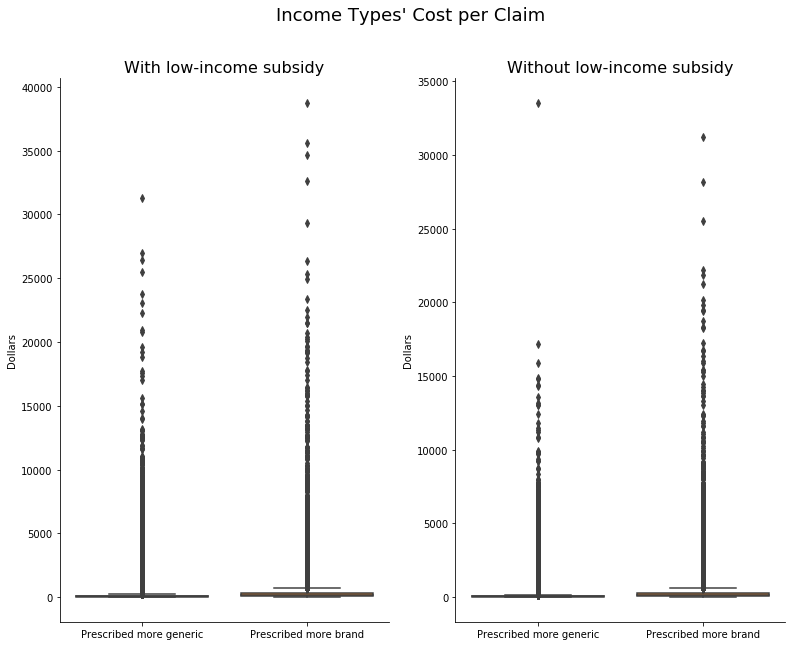

In [37]:
# create 1 overall figure with 2x2 Axes Subplots nested inside of it
fig, axarr = plt.subplots(1, 2, figsize=(13, 10))
fig.suptitle("Income Types' Cost per Claim", fontsize=18)

# tell pandas which subplot news plots to go in
sns.boxplot(x='prescribed_more_brand', y='lis_cost_per_claim', data=df, ax=axarr[0]);
axarr[0].set_title("With low-income subsidy", fontsize=16)
axarr[0].set_ylabel("Dollars")
axarr[0].set_xlabel("")
axarr[0].set_xticklabels(['Prescribed more generic', 'Prescribed more brand'])

sns.boxplot(x='prescribed_more_brand', y='nonlis_cost_per_claim', data=df, ax=axarr[1]);
axarr[1].set_title("Without low-income subsidy", fontsize=16)
axarr[1].set_ylabel("Dollars")
axarr[1].set_xlabel("")
axarr[1].set_xticklabels(['Prescribed more generic', 'Prescribed more brand'])

plt.subplots_adjust(hspace=.9)
sns.despine()

In [38]:
# OUTLIER ADD N6
outliers = outliers.append(df[df['lis_cost_per_claim']>20000]) # adds 9
outliers = outliers.append(df[df['nonlis_cost_per_claim']>20000]) # adds 3

outliers.loc[outliers['reason'].isnull(), 'reason'] = 'income'

outliers.shape

/Users/Olga/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(150, 62)

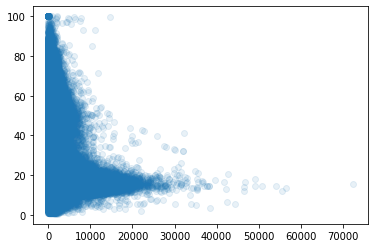

In [39]:
plt.scatter(df['nonlis_claim_count'], df['percent_prescribed_brand'], alpha=0.1);

**2.Insurance**

In [40]:
df['mapd_cost_per_claim'] = df['mapd_drug_cost'] / df['mapd_claim_count']
df['pdp_cost_per_claim'] = df['pdp_drug_cost'] / df['pdp_claim_count']

df['mapd_cost_per_claim'].fillna(0, inplace=True)
df['pdp_cost_per_claim'].fillna(0, inplace=True)

In [41]:
insurance = df[['mapd_cost_per_claim', 'pdp_cost_per_claim', 'mapd_claim_count', 'mapd_claim_count', 'mapd_drug_cost', 'pdp_drug_cost']]
insurance.groupby(df['prescribed_more_brand']).describe()

mapd_cost_per_claim                                \
                                    count        mean          std  min   
prescribed_more_brand                                                     
0                                500440.0  121.026019   378.408958  0.0   
1                                 40192.0  333.249326  1007.410643  0.0   

                                                                        \
                             25%         50%         75%           max   
prescribed_more_brand                                                    
0                      30.619321   55.546134   88.664288  65219.815263   
1                      82.642746  171.206296  300.303143  51354.637455   

                      pdp_cost_per_claim                               \
                                   count        mean         std  min   
prescribed_more_brand                                                   
0                               500440.0  127.674806  323.879044  0.0   
1                                40192.0  336.068970  868.179283  0.0   

                                                                         \
                              25%         50%         75%           max   
prescribed_more_brand                                                     
0                       37.448258   62.867355   99.945056  30429.002793   
1                      105.453936  189.750931  318.160160  41154.814146   

                      mapd_claim_count                                       \
                                 count         mean          std  min   25%   
prescribed_more_brand                                                         
0                             473211.0  1002.118042  2068.378590  0.0  69.0   
1                              34024.0   386.051052   756.540253  0.0  46.0   

                                                                       \
                         50%     75%       max     count         mean   
prescribed_more_brand                                                   
0                      225.0  1007.0  150723.0  473211.0  1002.118042   
1                      147.0   441.0   41032.0   34024.0   386.051052   

                                                                        \
                               std  min   25%    50%     75%       max   
prescribed_more_brand                                                    
0                      2068.378590  0.0  69.0  225.0  1007.0  150723.0   
1                       756.540253  0.0  46.0  147.0   441.0   41032.0   

                      mapd_drug_cost                                    \
                               count          mean            std  min   
prescribed_more_brand                                                    
0                           473211.0   83251.08003  186308.469367  0.0   
1                            34024.0  127824.34521  299882.745443  0.0   

                                                                     \
                             25%       50%         75%          max   
prescribed_more_brand                                                 
0                      3137.1600  17780.86   88551.045   9153529.39   
1                      8286.2375  32931.32  126463.795  15651625.50   

                      pdp_drug_cost                                     \
                              count           mean            std  min   
prescribed_more_brand                                                    
0                          473211.0  152293.083662  305985.406101  0.0   
1                           34024.0  248550.624646  479527.997079  0.0   

                                                                     
                            25%        50%         75%          max  
prescribed_more_brand                                                
0                       7048.76  41285.950  177158.905  13095826.04  
1                     

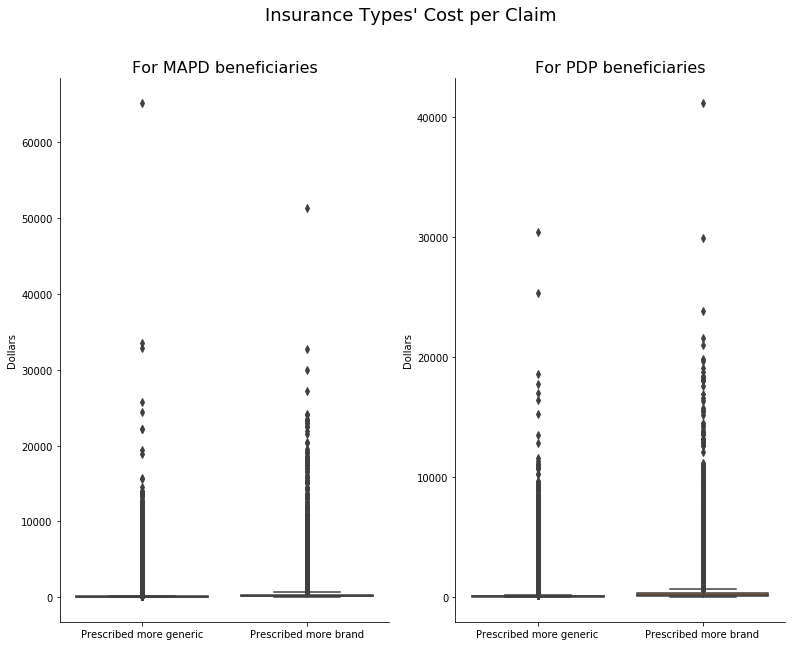

In [42]:
# create 1 overall figure with 2x2 Axes Subplots nested inside of it
fig, axarr = plt.subplots(1, 2, figsize=(13, 10))
fig.suptitle("Insurance Types' Cost per Claim", fontsize=18)

# tell pandas which subplot news plots to go in
sns.boxplot(x='prescribed_more_brand', y='mapd_cost_per_claim', data=df, ax=axarr[0]);
axarr[0].set_title("For MAPD beneficiaries", fontsize=16)
axarr[0].set_ylabel("Dollars")
axarr[0].set_xlabel("")
axarr[0].set_xticklabels(['Prescribed more generic', 'Prescribed more brand'])

sns.boxplot(x='prescribed_more_brand', y='pdp_cost_per_claim', data=df, ax=axarr[1]);
axarr[1].set_title("For PDP beneficiaries", fontsize=16)
axarr[1].set_ylabel("Dollars")
axarr[1].set_xlabel("")
axarr[1].set_xticklabels(['Prescribed more generic', 'Prescribed more brand'])

plt.subplots_adjust(hspace=.9)
sns.despine()

In [43]:
# OUTLIER ADD N7
outliers = outliers.append(df[df['mapd_cost_per_claim']>20000]) # adds 
outliers = outliers.append(df[df['pdp_cost_per_claim']>20000]) # adds 

outliers.loc[outliers['reason'].isnull(), 'reason'] = 'Insurance'

outliers.shape

/Users/Olga/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(181, 64)

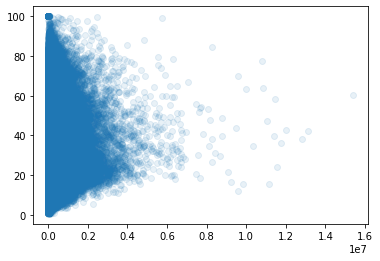

In [44]:
plt.scatter(df['pdp_drug_cost'], df['percent_prescribed_brand'], alpha=0.1);

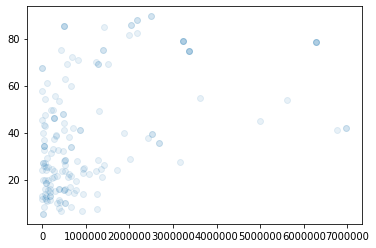

In [45]:
plt.scatter(outliers['pdp_drug_cost'], outliers['percent_prescribed_brand'], alpha=0.1);

# Risk

prescribed_more_brand
0    0.356757
1    0.340331
Name: log_beneficiary_average_risk_score, dtype: float64


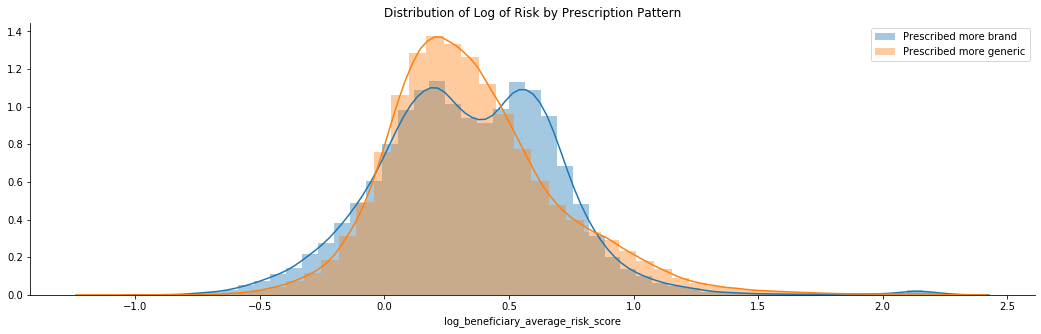

In [46]:
df['log_beneficiary_average_risk_score'] = np.log(df['beneficiary_average_risk_score'])

# exploring log of closest scooter feature
print(df.groupby('prescribed_more_brand')['log_beneficiary_average_risk_score'].mean())

# create stratified log of closest scooter in meters by nest_dummy
more_brand = df['log_beneficiary_average_risk_score'][df['prescribed_more_brand'] == 1]
less_brand = df['log_beneficiary_average_risk_score'][df['prescribed_more_brand'] == 0]

fig, (ax18) = plt.subplots(1, 1, figsize=(18, 5))

sns.distplot(more_brand, label='Prescribed more brand')
sns.distplot(less_brand, label='Prescribed more generic')

plt.title('Distribution of Log of Risk by Prescription Pattern')
plt.legend()
sns.despine()

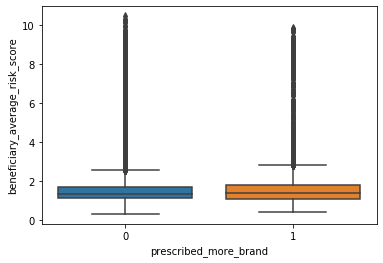

In [47]:
sns.boxplot(x='prescribed_more_brand', y='beneficiary_average_risk_score', data=df);

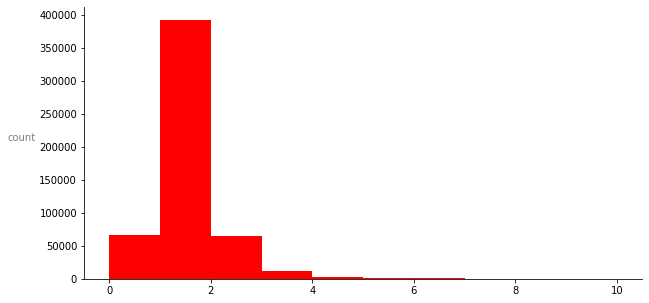

In [48]:
# OKAY
plt.figure(figsize=(10, 5))
plt.hist(df['beneficiary_average_risk_score'].astype(int).sort_index(), color='red')
# plt.xlabel('Percent prescribed brand', color='gray')
plt.ylabel('count', color='gray', rotation='horizontal', horizontalalignment='right')
# plt.title('Distribution of brand prescribing pattern', fontsize=18)
# plt.xlim(0, None)
# plt.xticks(range(0, 101, 10))    
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False);

### OUTLIER ANALYSIS

In [49]:
# df_one_hot.isin(['total_drug_cost'])
if 'total_drug_cost' in df.columns:
    print('yes')

In [50]:
# NEED TO DROP THE ORIGINAL OF THE ENGINEERED not to have collinearity
outliers = outliers.drop(['brand_drug_cost', 'brand_claim_count', 'generic_drug_cost', 'generic_claim_count', 
              'opioid_claim_count', 'opioid_drug_cost', 'opioid_bene_count',
              'la_opioid_claim_count', 'la_opioid_drug_cost', 'la_opioid_bene_count', 
              'antibiotic_claim_count', 'antibiotic_drug_cost', 'antibiotic_bene_count', 
              'antipsych_claim_count_ge65', 'antipsych_drug_cost_ge65', 'antipsych_bene_count_ge65',
              'mapd_claim_count','mapd_drug_cost', 'pdp_claim_count', 'pdp_drug_cost',
              'lis_claim_count', 'lis_drug_cost', 'nonlis_claim_count','nonlis_drug_cost'], axis=1)

In [51]:
non_outliers = df.loc[~df.npi.isin(outliers.npi)]
non_outliers = non_outliers.drop(['brand_drug_cost', 'brand_claim_count', 'generic_drug_cost', 'generic_claim_count', 
              'opioid_claim_count', 'opioid_drug_cost', 'opioid_bene_count',
              'la_opioid_claim_count', 'la_opioid_drug_cost', 'la_opioid_bene_count', 
              'antibiotic_claim_count', 'antibiotic_drug_cost', 'antibiotic_bene_count', 
              'antipsych_claim_count_ge65', 'antipsych_drug_cost_ge65', 'antipsych_bene_count_ge65',
              'mapd_claim_count','mapd_drug_cost', 'pdp_claim_count', 'pdp_drug_cost',
              'lis_claim_count', 'lis_drug_cost', 'nonlis_claim_count','nonlis_drug_cost'], axis=1)

In [52]:
outliers.describe()

,antibiotic_claim_per_bene,antibiotic_cost_per_bene,antibiotic_cost_per_claim,antipsych_claim_per_bene_ge65,antipsych_cost_per_bene_ge65,antipsych_cost_per_claim_ge65,average_age_of_beneficiaries,beneficiary_average_risk_score,brand_cost_per_claim,generic_cost_per_claim,la_opioid_claim_per_bene,la_opioid_cost_per_bene,la_opioid_cost_per_claim,la_opioid_day_supply,la_opioid_prescriber_rate,lis_cost_per_claim,mapd_cost_per_claim,nonlis_cost_per_claim,npi,opioid_claim_per_bene,opioid_cost_per_bene,opioid_cost_per_claim,opioid_day_supply,opioid_prescriber_rate,pdp_cost_per_claim,percent_prescribed_brand,prescribed_more_brand
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.00000,181.000000,181.000000,181.000000,181.000000,168.000000,168.000000,168.000000,173.000000,98.000000,65.000000,31.000000,65.000000,1.810000e+02,168.000000,168.000000,168.000000,152.000000,152.000000,31.000000,181.000000,181.000000
mean,1.396149,668.345936,398.395414,2.556776,667.656119,189.72767,65.232044,1.832914,11981.573060,319.889199,3.086667,1229.767070,332.051758,2034.092486,19.622653,19623.115122,24280.511048,13098.631701,1.452488e+09,5.544759,3548.166434,591.475070,7001.394737,13.654145,13323.532476,39.986262,0.287293
std,3.288237,3535.071066,934.854095,9.813164,2855.271949,700.30056,7.066452,0.709492,14136.973507,1020.372039,7.562339,3446.387112,1152.901134,5487.857633,18.606002,10139.499872,11915.667694,10314.716434,2.887997e+08,9.680489,7904.460611,1554.527436,15587.086867,23.339401,11415.523981,25.197841,0.453755
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,48.000000,0.769100,77.286519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.078846,0.000000,1.003205e+09,0.000000,0.000000,0.000000,0.000000,0.000000,48.695376,4.598768,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,61.000000,1.363200,896.244800,27.248621,0.000000,0.000000,0.000000,0.000000,0.000000,14207.008421,21719.960364,2732.701682,1.205808e+09,0.000000,0.000000,0.000000,0.000000,0.000000,2386.537124,19.811321,0.000000
50%,0.000000,0.000000,5.958710,0.000000,0.000000,0.00000,66.000000,1.684600,4292.694375,46.498566,0.000000,0.000000,0.000000,0.000000,14.940000,21476.980116,23014.684286,14364.204165,1.427057e+09,0.000000,0.000000,0.000000,106.000000,0.910000,13090.190060,33.752860,0.000000
75%,1.435819,21.118329,29.249336,0.000000,0.000000,0.00000,70.000000,2.063100,22544.654237,111.640105,0.000000,0.000000,113.477245,1140.000000,35.140000,25316.888421,25112.952397,21205.539226,1.689735e+09,7.206834,1819.129923,156.112850,5055.750000,14.075000,20994.963571,60.000000,1.000000
max,20.642857,27382.930588,3236.746364,60.066667,16467.361667,4792.52750,88.000000,3.994100,52098.112083,6472.651389,46.304348,17120.757500,9881.284286,32754.000000,56.140000,38745.381250,65219.815263,33519.497105,1.992098e+09,38.333333,40533.024737,8481.210901,71819.000000,83.430000,41154.814146,100.000000,1.000000


In [53]:
non_outliers.describe()

,npi,opioid_day_supply,opioid_prescriber_rate,la_opioid_day_supply,la_opioid_prescriber_rate,average_age_of_beneficiaries,beneficiary_average_risk_score,percent_prescribed_brand,prescribed_more_brand,brand_cost_per_claim,generic_cost_per_claim,opioid_claim_per_bene,opioid_cost_per_bene,opioid_cost_per_claim,la_opioid_claim_per_bene,la_opioid_cost_per_bene,la_opioid_cost_per_claim,antibiotic_claim_per_bene,antibiotic_cost_per_bene,antibiotic_cost_per_claim,antipsych_claim_per_bene_ge65,antipsych_cost_per_bene_ge65,antipsych_cost_per_claim_ge65,lis_cost_per_claim,nonlis_cost_per_claim,mapd_cost_per_claim,pdp_cost_per_claim,log_beneficiary_average_risk_score
count,5.404860e+05,420998.000000,420998.000000,460406.000000,313728.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000,540486.000000
mean,1.499554e+09,3355.828094,7.578496,461.800417,5.216630,69.767167,1.528034,21.685233,0.074302,536.268199,31.236614,1.384503,55.201158,14.608848,0.306614,57.307517,29.750985,0.925505,41.408925,24.759637,0.434551,48.711344,19.986731,166.217131,123.238595,135.287799,142.212063,0.355490
std,2.879437e+08,10616.244841,13.397664,2577.392524,10.626612,6.000346,0.674906,15.740326,0.262261,1108.987669,44.450362,2.067288,196.467378,36.215186,1.376645,326.736351,100.329864,0.881881,261.649612,103.368391,1.764447,301.952547,80.739820,458.798888,348.965500,411.624224,372.720369,0.350603
min,1.003000e+09,0.000000,0.000000,0.000000,0.000000,11.000000,0.311000,0.453278,0.000000,1.290000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.167962
25%,1.245660e+09,0.000000,0.000000,0.000000,0.000000,67.000000,1.130400,12.714777,0.000000,174.948437,16.704838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.540530,30.411396,31.368747,38.335747,0.122572
50%,1.497932e+09,289.000000,2.500000,0.000000,0.000000,71.000000,1.365200,17.040359,0.000000,266.346689,22.947428,0.000000,0.000000,3.099167,0.000000,0.000000,0.000000,1.111111,10.617085,9.361879,0.000000,0.000000,0.000000,70.069575,53.531967,57.725423,65.262570,0.311301
75%,1.740710e+09,2619.000000,7.640000,0.000000,5.990000,74.000000,1.722600,24.050633,0.000000,405.712038,32.770833,2.270833,36.098301,16.915341,0.000000,0.000000,0.000000,1.508772,22.774664,16.148291,0.000000,0.000000,0.000000,120.580878,93.531188,98.537906,112.396342,0.543835
max,1.993000e+09,615456.000000,100.000000,165740.000000,100.000000,94.000000,10.460400,100.000000,1.000000,29825.580833,3496.566598,24.886364,14232.238519,2877.223200,19.916667,9967.714444,3766.061429,12.384615,14986.765000,2493.768571,39.142857,12473.686667,2453.201429,19584.155478,19394.666818,19405.697333,19793.078765,2.347597


In [54]:
outliers.groupby(outliers['prescribed_more_brand']).describe()

antibiotic_claim_per_bene                                \
                                          count      mean       std  min  25%   
prescribed_more_brand                                                           
0                                         120.0  1.849506  3.747612  0.0  0.0   
1                                          48.0  0.262756  1.011187  0.0  0.0   

                                                antibiotic_cost_per_bene  \
                       50%       75%        max                    count   
prescribed_more_brand                                                      
0                      0.0  1.796566  20.642857                    120.0   
1                      0.0  0.000000   6.454545                     48.0   

                                                                          \
                             mean          std  min  25%  50%        75%   
prescribed_more_brand                                                      
0                      839.225876  4044.383792  0.0  0.0  0.0  38.291454   
1                      241.146085  1651.573788  0.0  0.0  0.0   0.000000   

                                    antibiotic_cost_per_claim              \
                                max                     count        mean   
prescribed_more_brand                                                       
0                      27382.930588                     120.0  467.242687   
1                      11444.972727                      48.0  226.277230   

                                                                    \
                               std  min  25%        50%        75%   
prescribed_more_brand                                                
0                      1015.466380  0.0  0.0  14.293248  71.476343   
1                       672.400774  0.0  0.0   0.000000   0.000000   

                                   antipsych_claim_per_bene_ge65            \
                               max                         count      mean   
prescribed_more_brand                                                        
0                      3236.746364                         120.0  3.579486   
1                      2860.905714                          48.0  0.000000   

                                                                 \
                             std  min  25%  50%  75%        max   
prescribed_more_brand                                             
0                      11.465148  0.0  0.0  0.0  0.0  60.066667   
1                       0.000000  0.0  0.0  0.0  0.0   0.000000   

                      antipsych_cost_per_bene_ge65                           \
                                             count        mean          std   
prescribed_more_brand                                                         
0                                            120.0  934.718567  3345.039124   
1                                             48.0    0.000000     0.000000   

                                                         \
                       min  25%  50%  75%           max   
prescribed_more_brand                                     
0                      0.0  0.0  0.0  0.0  16467.361667   
1                      0.0  0.0  0.0  0.0      0.000000   

                      antipsych_cost_per_claim_ge65                          \
                                              count        mean         std   
prescribed_more_brand                                                         
0                                             120.0  244.611974  790.771453   
1                                              48.0   52.516910  363.847824   

                                                              \
                       min  25%  50%        75%          max   
prescribed_more_brand                                          
0                      0.0  0.0  0.0  18.930554  4792.527500   
1                      0.0  0.0  0.0   0.00000

In [55]:
non_outliers.sort_index().groupby(non_outliers['prescribed_more_brand']).describe()


npi                                            \
                          count          mean           std           min   
prescribed_more_brand                                                       
0                      500327.0  1.499383e+09  2.879510e+08  1.003000e+09   
1                       40159.0  1.501694e+09  2.878482e+08  1.003001e+09   

                                                                               \
                                25%           50%           75%           max   
prescribed_more_brand                                                           
0                      1.245653e+09  1.497917e+09  1.740691e+09  1.993000e+09   
1                      1.255317e+09  1.508157e+09  1.750357e+09  1.992998e+09   

                      opioid_day_supply                                       \
                                  count         mean           std  min  25%   
prescribed_more_brand                                                          
0                              390679.0  3613.153292  10977.606804  0.0  0.0   
1                               30319.0    40.034335    555.156605  0.0  0.0   

                                               opioid_prescriber_rate  \
                         50%     75%       max                  count   
prescribed_more_brand                                                   
0                      390.0  2991.0  615456.0               390679.0   
1                        0.0     0.0   59661.0                30319.0   

                                                                         \
                           mean        std  min  25%   50%   75%    max   
prescribed_more_brand                                                     
0                      8.144342  13.732912  0.0  0.0  2.96  8.41  100.0   
1                      0.287218   2.237978  0.0  0.0  0.00  0.00   84.0   

                      la_opioid_day_supply                                     \
                                     count        mean          std  min  25%   
prescribed_more_brand                                                           
0                                 421540.0  503.904401  2689.064437  0.0  0.0   
1                                  38866.0    5.141306   191.087496  0.0  0.0   

                                          la_opioid_prescriber_rate            \
                       50%  75%       max                     count      mean   
prescribed_more_brand                                                           
0                      0.0  0.0  165740.0                  303225.0  5.364315   
1                      0.0  0.0   28803.0                   10503.0  0.952910   

                                                              \
                             std  min  25%  50%   75%    max   
prescribed_more_brand                                          
0                      10.688862  0.0  0.0  0.0  6.69  100.0   
1                       7.470822  0.0  0.0  0.0  0.00  100.0   

                      average_age_of_beneficiaries                             \
                                             count       mean       std   min   
prescribed_more_brand                                                           
0                                         500327.0  69.662709  6.052101  11.0   
1                                          40159.0  71.068577  5.138461  25.0   

                                              beneficiary_average_risk_score  \
                        25%   50%   75%   max                          count   
prescribed_more_brand                                                          
0                      67.0  71.0  73.0  94.0                       500327.0   
1                      69.0  72.0  74.0  90.0                        40159.0   

                                                                             \
                           mean       std     min      25%     50%      75

In [56]:
non_outliers.shape

(540486, 40)

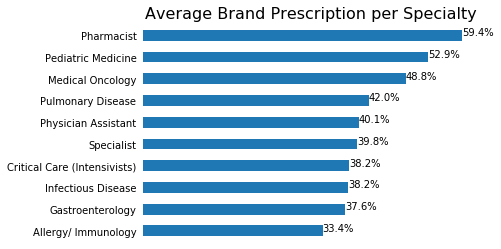

In [57]:
# Average prescription per specialty AMONG OUTLIERS

plt.figure()

ax = outliers['percent_prescribed_brand'].groupby(df['specialty_description']).mean().sort_values(ascending=True).tail(10).plot(kind='barh', width=0.5)

plt.title("Average Brand Prescription per Specialty", fontsize= 16)
plt.xticks([])
plt.ylabel('')
plt.xticks([])

ax.tick_params(left=False, labelleft=True)
           
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False);
plt.gca().spines['right'].set_visible(False);

ax.spines['left'].set_visible(False)

total = len(df['percent_prescribed_brand'].groupby(df['specialty_description']).mean())
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
        
plt.show()

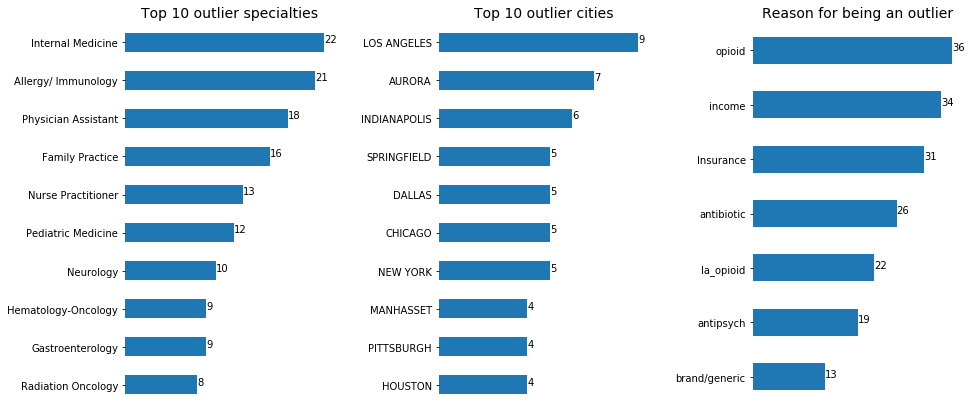

In [58]:
# WHAT THEY DO, WHERE THEY LIVE
fig, axarr = plt.subplots(1, 3, figsize=(15, 7))

outliers['specialty_description'].value_counts()[:10].sort_values().plot(kind='barh', ax=axarr[0]);
axarr[0].set_title("Top 10 outlier specialties", fontsize=14)
for p in axarr[0].patches:
    count = p.get_width()
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    axarr[0].annotate(count, (x, y))

outliers['nppes_provider_city'].value_counts()[:10].sort_values().plot(kind='barh', ax=axarr[1]);
axarr[1].set_title("Top 10 outlier cities", fontsize=14)
for p in axarr[1].patches:
    count = p.get_width()
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    axarr[1].annotate(count, (x, y))

# outliers['reason'].value_counts()    
outliers['reason'].value_counts()[:10].sort_values().plot(kind='barh', ax=axarr[2]);
axarr[2].set_title("Reason for being an outlier", fontsize=14)
for p in axarr[2].patches:
    count = p.get_width()
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    axarr[2].annotate(count, (x, y))    
    
for ax in axarr:
    ax.set_xlabel("")
    ax.spines['bottom'].set_visible(False);
    ax.spines['top'].set_visible(False);
    ax.spines['left'].set_visible(False);
    ax.spines['right'].set_visible(False);
    ax.set_xticks([])
    
plt.subplots_adjust(wspace=.5)

In [88]:
full_corr = outliers.drop(['brand_cost_per_claim','generic_cost_per_claim'], axis=1).corr()['percent_prescribed_brand'].sort_values()
top10_corr = pd.concat([full_corr[:5],  full_corr[-7:-2]])
top10_corr.reindex(top10_corr.abs().sort_values(ascending=False).index)

nonlis_cost_per_claim             0.576560
pdp_cost_per_claim                0.484523
la_opioid_prescriber_rate        -0.454956
opioid_claim_per_bene            -0.431869
opioid_prescriber_rate           -0.364436
la_opioid_claim_per_bene         -0.364383
average_age_of_beneficiaries     -0.334875
lis_cost_per_claim                0.283848
antibiotic_cost_per_bene          0.024989
beneficiary_average_risk_score    0.022957
Name: percent_prescribed_brand, dtype: float64

In [60]:
full_corr = non_outliers.drop(['brand_cost_per_claim','generic_cost_per_claim'], axis=1).corr()['percent_prescribed_brand'].sort_values()
top10_corr = pd.concat([full_corr[:5],  full_corr[-7:-2]])
top10_corr.reindex(top10_corr.abs().sort_values(ascending=False).index)

opioid_prescriber_rate          -0.277837
opioid_claim_per_bene           -0.232945
nonlis_cost_per_claim            0.217178
pdp_cost_per_claim               0.215996
mapd_cost_per_claim              0.192914
lis_cost_per_claim               0.184984
antibiotic_claim_per_bene       -0.179036
average_age_of_beneficiaries     0.125838
opioid_day_supply               -0.117376
antipsych_claim_per_bene_ge65   -0.114517
Name: percent_prescribed_brand, dtype: float64

In [62]:
outliers['npi'].value_counts()[outliers['npi'].value_counts().values>2]

1083822803    4
1689734741    4
1205896933    4
1881650596    3
1073772851    3
1457439713    3
Name: npi, dtype: int64

In [63]:
# practitioners guilty of more than one outlier aspect 
biggest_offenders_list = outliers['npi'].value_counts().index[outliers['npi'].value_counts().values>2]
biggest_offenders_df = outliers.loc[outliers['npi'].isin(biggest_offenders_list)].sort_index()
biggest_offenders_df.shape

(21, 40)

In [64]:
# States sorted by the highers cost per claim among outliers, top 5
mean_brand = outliers.groupby('nppes_provider_state')['brand_cost_per_claim'].agg('mean')
mean_generic = outliers.groupby('nppes_provider_state')['generic_cost_per_claim'].agg('mean')

outliers.groupby('nppes_provider_state')['brand_cost_per_claim','generic_cost_per_claim'].agg('mean').sort_values(ascending=False, by='brand_cost_per_claim').head()


,brand_cost_per_claim,generic_cost_per_claim
nppes_provider_state,,
NM,27019.977000,60.264722
CO,26245.251371,52.647501
VA,24803.986662,20.448541
OH,21930.690281,30.828232
MI,20952.980504,74.603520


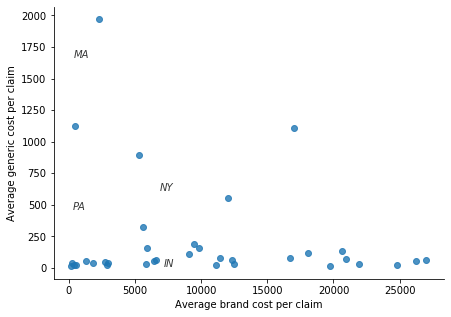

In [65]:
plt.figure(figsize=(7, 5))

plt.scatter(mean_brand, mean_generic, alpha=0.8);
# plt.scatter(df['percent_prescribed_brand'],df['bene_count'], color='green', alpha=0.8);

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel("Average brand cost per claim")
plt.ylabel("Average generic cost per claim")

# Annotate doctors with high generic cost per claim
plt.annotate('MA', (403.895544, 1666.878283), 
             fontsize=10,
             fontstyle='italic', 
             color='xkcd:dark grey')
plt.annotate('IN', (7197.940131, 13.308205), 
             fontsize=10,
             fontstyle='italic', 
             color='xkcd:dark grey')
plt.annotate("NY", (6862.957940, 610.347534), 
             fontsize=10,
             fontstyle='italic', 
             color='xkcd:dark grey')

plt.annotate("PA", (296.970647, 458.745745), 
             fontsize=10,
             fontstyle='italic', 
             color='xkcd:dark grey');

# Modelling

In [73]:
# NEED TO DROP THE ORIGINAL OF THE ENGINEERED not to have collinearity
df = df.drop(['brand_drug_cost', 'brand_claim_count', 'generic_drug_cost', 'generic_claim_count', 
              'opioid_claim_count', 'opioid_drug_cost', 'opioid_bene_count',
              'la_opioid_claim_count', 'la_opioid_drug_cost', 'la_opioid_bene_count', 
              'antibiotic_claim_count', 'antibiotic_drug_cost', 'antibiotic_bene_count', 
              'antipsych_claim_count_ge65', 'antipsych_drug_cost_ge65', 'antipsych_bene_count_ge65',
              'mapd_claim_count','mapd_drug_cost', 'pdp_claim_count', 'pdp_drug_cost',
              'lis_claim_count', 'lis_drug_cost', 'nonlis_claim_count','nonlis_drug_cost'], axis=1)

# IDENTIFYING FEATURES used to look at outliers, no need in modelling
df = df.drop(['nppes_credentials',  'nppes_provider_mi', 'nppes_provider_last_org_name', 'nppes_provider_first_name'], axis=1)

In [74]:
df.shape

(540632, 36)

In [75]:
df_dropped = df.dropna(how='any')
df_dropped.shape
# df_filled = df.fillna(5).astype(int)
# df_filled.shape

(206116, 36)

In [76]:
df_dropped.columns

Index(['npi', 'nppes_provider_gender', 'nppes_entity_code',
       'nppes_provider_city', 'nppes_provider_zip5', 'nppes_provider_state',
       'nppes_provider_country', 'specialty_description',
       'medicare_prvdr_enroll_status', 'opioid_day_supply',
       'opioid_prescriber_rate', 'la_opioid_day_supply',
       'la_opioid_prescriber_rate', 'average_age_of_beneficiaries',
       'beneficiary_average_risk_score', 'percent_prescribed_brand',
       'prescribed_more_brand', 'brand_cost_per_claim',
       'generic_cost_per_claim', 'opioid_claim_per_bene',
       'opioid_cost_per_bene', 'opioid_cost_per_claim',
       'la_opioid_claim_per_bene', 'la_opioid_cost_per_bene',
       'la_opioid_cost_per_claim', 'antibiotic_claim_per_bene',
       'antibiotic_cost_per_bene', 'antibiotic_cost_per_claim',
       'antipsych_claim_per_bene_ge65', 'antipsych_cost_per_bene_ge65',
       'antipsych_cost_per_claim_ge65', 'lis_cost_per_claim',
       'nonlis_cost_per_claim', 'mapd_cost_per_claim', 'p

In [77]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
df_one_hot = pd.get_dummies(df_dropped, sparse=True, drop_first=True)
df_one_hot.shape

(206116, 24016)

In [81]:
# # from sklearn.decomposition import PCA
# # pca = PCA(n_components=0.95)
# # X_reduced = pca.fit_transform(X)
# # X_reduced.shape
# df_one_hot_sparse = df_one_hot.to_sparse()
# df_one_hot_sparse.shape

(206116, 24016)

In [78]:
# X = df_one_hot.loc[:, df_one_hot.columns != 'percent_prescribed_brand']
# X = df_one_hot.drop(['percent_prescribed_brand'], axis=1)

# y = df_one_hot[['percent_prescribed_brand']].copy()
y = df_one_hot['percent_prescribed_brand'].ravel()
# y = df_one_hot_sparse['percent_prescribed_brand']

# ALL
# # X = df_one_hot.drop(['percent_prescribed_brand', 'prescribed_more_brand'], axis=1)
X = df_one_hot.drop(['percent_prescribed_brand', 'prescribed_more_brand', 
                     'brand_cost_per_claim', 'generic_cost_per_claim'], axis=1)
# ALL but engineered
# X = df_one_hot.drop(['percent_prescribed_brand', 'prescribed_more_brand', 'brand_cost_per_claim', 'generic_cost_per_claim', 'opioid_claim_per_bene',
#         'opioid_cost_per_bene', 'opioid_cost_per_claim', 'la_opioid_claim_per_bene', 
#         'la_opioid_cost_per_bene', 'la_opioid_cost_per_claim', 'antibiotic_claim_per_bene',
#        'antibiotic_cost_per_bene', 'antibiotic_cost_per_claim', 'antipsych_claim_per_bene_ge65', 
#         'antipsych_cost_per_bene_ge65', 'antipsych_cost_per_claim_ge65', 'lis_cost_per_claim',
#        'nonlis_cost_per_claim', 'mapd_cost_per_claim', 'pdp_cost_per_claim',
#         'average_age_of_beneficiaries','beneficiary_average_risk_score'], axis=1)
## ENGINEERED FEATURES
# X = df[['brand_cost_per_claim', 'generic_cost_per_claim', 'opioid_claim_per_bene',
#         'opioid_cost_per_bene', 'opioid_cost_per_claim', 'la_opioid_claim_per_bene', 
#         'la_opioid_cost_per_bene', 'la_opioid_cost_per_claim', 'antibiotic_claim_per_bene',
#        'antibiotic_cost_per_bene', 'antibiotic_cost_per_claim', 'antipsych_claim_per_bene_ge65', 
#         'antipsych_cost_per_bene_ge65', 'antipsych_cost_per_claim_ge65', 'lis_cost_per_claim',
#        'nonlis_cost_per_claim', 'mapd_cost_per_claim', 'pdp_cost_per_claim',
#         'average_age_of_beneficiaries','beneficiary_average_risk_score']]
## BEST FEATURES, per Random Forest 1
# X = df_one_hot[['pdp_drug_cost', 'lis_drug_cost','lis_claim_count', 'nonlis_claim_count', 
# 'antipsych_drug_cost_ge65', 'nppes_provider_state_FL', 'beneficiary_age_65_74_count', 
# 'antibiotic_cost_per_claim', 'antipsych_claim_per_bene_ge65', 'antibiotic_claim_per_bene', 
# 'beneficiary_average_risk_score', 'total_day_supply', 'generic_cost_per_claim', 
# 'antipsych_cost_per_claim_ge65', 'antipsych_cost_per_bene_ge65', 'total_day_supply_ge65', 
# 'opioid_day_supply', 'nonlis_drug_cost', 'nppes_provider_city_NEWTON', 
# 'la_opioid_prescriber_rate']].copy()

## BEST FEATURES, per Random Forest 2
# ['antibiotic_bene_count', 'total_day_supply', 'total_drug_cost', 'total_drug_cost_ge65', 'pdp_drug_cost'] not in index"
# X = df_one_hot[['pdp_cost_per_claim', 'nonlis_cost_per_claim', 'specialty_description_Ophthalmology',
# 'lis_cost_per_claim','opioid_prescriber_rate','mapd_cost_per_claim','beneficiary_average_risk_score',
# 'antibiotic_claim_per_bene','opioid_day_supply','specialty_description_Dermatology',
# 'specialty_description_Obstetrics & Gynecology', 
# 'opioid_claim_per_bene']] # minus 'lis_drug_cost', 'opioid_bene_count','opioid_claim_count'

In [81]:
X.shape


(206116, 24012)

In [82]:
y.shape


(206116,)

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# Xs = scaler.fit_transform(X)
# # Xs_top20 = scaler.fit_transform(X)

In [83]:
# Split into validation and training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)#, test_size=0.5, random_state=1)

# Regression
### 1. Baseline 

In [84]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
def print_scores(model):
    model_pred = model.predict(X_test)
    print("R2: ", model.score(X_test, y_test))
    print("RMSE: ", np.sqrt(mean_squared_error(y_test, model_pred)))
    print("MSE: ", mean_squared_error(y_test, model_pred))
    print("MAE: ", mean_absolute_error(y_test, model_pred))
#     scores = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=4))
#     print("Cross validated RMSE's mean: ", scores.mean())
#     print("Cross validated RMSE's Standard deviation: ", scores.std())

In [ ]:
# # BASELINE 
# from sklearn.linear_model import LinearRegression
# linear_reg = LinearRegression().fit(X_train, y_train)
# lin_pred = linear_reg.predict(X_test)
# # import statsmodels.api as sm
# # model = sm.OLS(y_train, X_train).fit()
# # print(model.bse.mean())
# print_scores(linear_reg)

In [ ]:
# from sklearn.linear_model import LinearRegression
# linear_reg = LinearRegression().fit(X_train, y_train)
# lin_pred = linear_reg.predict(X_test)
# # import statsmodels.api as sm
# # model = sm.OLS(y_train, X_train).fit()
# # print(model.bse.mean())
# print_scores(linear_reg)

In [ ]:
# # BASELINE TOP 20
# linear_reg_top20 = LinearRegression().fit(X_train, y_train)
# lin_pred_top20 = linear_reg_top20.predict(X_test)
# print_scores(linear_reg_top20)

In [ ]:
# # BASELINE with imputed missing
# linear_reg_imputed = LinearRegression().fit(X_train, y_train)
# lin_pred_imputed = linear_reg_imputed.predict(X_test)
# print_scores(linear_reg_imputed)

In [ ]:
# # BASELINE with imputed and scaled
# linear_reg_imputed_scaled = LinearRegression().fit(Xs_train, y_train)
# lin_pred_imputed_scaled = linear_reg_imputed_scaled.predict(X_test)
# print_scores(linear_reg_imputed_scaled)

In [ ]:
# # BASELINE with engineered
# linear_reg_engineered = LinearRegression().fit(X_train, y_train)
# lin_pred_engineered = linear_reg_engineered.predict(X_test)
# print_scores(linear_reg_engineered)

### 2. Decision trees
*Don't require scaling or centering

In [85]:
from sklearn.tree import DecisionTreeRegressor

In [86]:
tree_reg = DecisionTreeRegressor(criterion='mse', max_depth=5)
tree_reg.fit(X_train, y_train);
tree_pred = tree_reg.predict(X_test)
print_scores(tree_reg)

R2:  0.4350035750186531
RMSE:  5.784439772782107
MSE:  33.45974348494351
MAE:  3.8313803044492825


In [303]:
# tree_reg_top20 = DecisionTreeRegressor(criterion='mse', max_depth=5)
# tree_reg_top20.fit(X_train, y_train);
# tree_pred_top20 = tree_reg_top20.predict(X_test)
# print_scores(tree_reg_top20)

R2:  0.4429913656860651
RMSE:  5.781450331447539
MSE:  33.42516793499486
MAE:  3.835734069500311


In [ ]:
# tree_reg_engineered = DecisionTreeRegressor(criterion='mse', max_depth=5)
# tree_reg_engineered.fit(X_train, y_train);
# tree_pred_engineered = tree_reg_engineered.predict(X_test)
# print_scores(tree_reg_engineered)

/Users/Olga/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


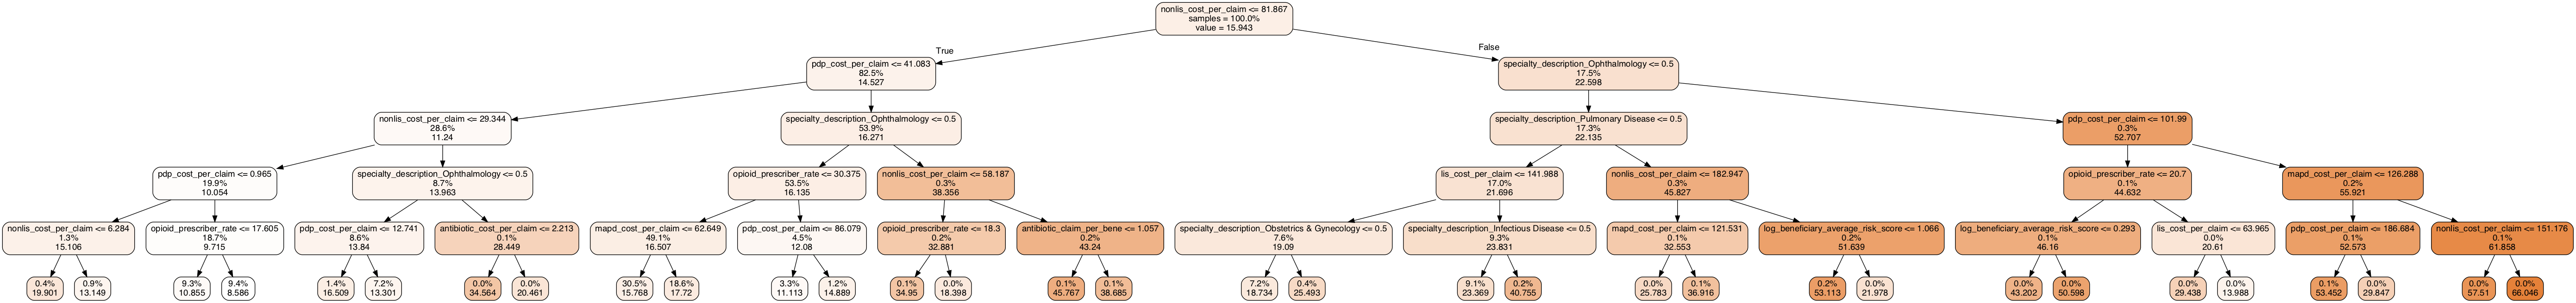

In [87]:
from sklearn.externals.six import StringIO 
from IPython.display import Image 
from sklearn.tree import export_graphviz
import pydotplus

def print_graph(clf, feature_names):
    """Print decision tree."""
    graph = export_graphviz(
        clf,
        label="root",
        proportion=True,
        impurity=False,
        out_file=None,
        feature_names=feature_names,
        class_names={0: "D", 1: "R"},
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)
    return Image(graph.create_png())
print_graph(tree_reg, X.columns)

# dot_data = export_graphviz(tree_reg, feature_names = X.columns,
#                            out_file=None,
# #                            out_file=dot_data, 
#                filled=True, rounded=True,
#                special_characters=True) 
# graph = pydotplus.graph_from_dot_data(dot_data)
# graph.set_size(20,20)
# graph.write_png('tree_all_features_bad_missing_analysis.png')

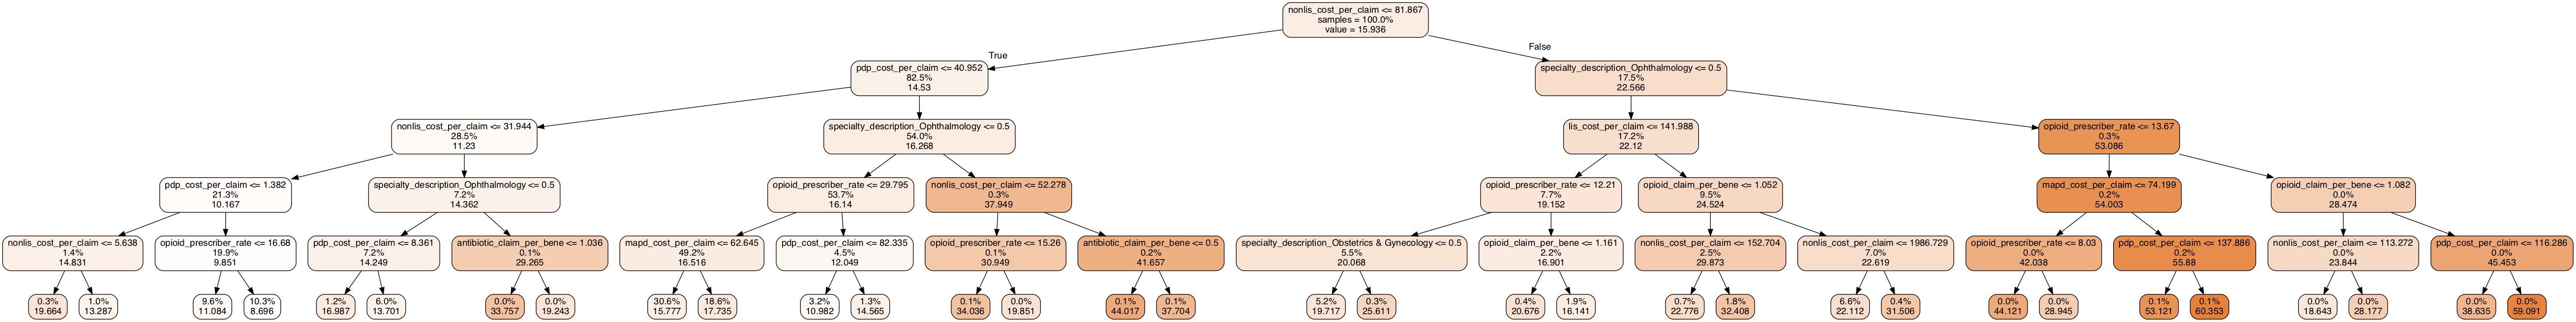

In [311]:
print_graph(tree_reg_top20, X.columns)

In [312]:
dot_data = export_graphviz(tree_reg_top20, feature_names = X.columns,
                           out_file=None,
#                            out_file=dot_data, 
               filled=True, rounded=True,
               special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size(20,20)
graph.write_png('tree_engineered.png')

InvocationException: Program terminated with status: 1. stderr follows: Error: not well-formed (invalid token) in line 1 
... <HTML>specialty_description_Obstetrics & Gynecology &le; 0.5 ...
in label of node 35


**Discuss the tree! how it makes decisions etc. like here https://www.dataquest.io/blog/introduction-to-ensembles/**

In [ ]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(5)
plot_lm_1.set_figwidth(7)
plot_lm_1.axes[0] = sns.residplot(tree_pred, y_test) 
plot_lm_1.axes[0].set_title('Tree Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')
sns.despine()

In [ ]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(5)
plot_lm_1.set_figwidth(7)
plot_lm_1.axes[0] = sns.residplot(tree_pred_top20, y_test) 
plot_lm_1.axes[0].set_title('Tree Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')
sns.despine()

In [ ]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(5)
plot_lm_1.set_figwidth(7)
plot_lm_1.axes[0] = sns.residplot(tree_pred_engineered, y_test) 
plot_lm_1.axes[0].set_title('Tree Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')
sns.despine()

### 3. Random Forest

An ensemble of Decision trees is a Random Forest. Random Forests performs Bagging internally. Random Forest creates several trees, sometimes thousands, and calculates the best possible model for a given dataset. Instead of considering all features while splitting a node, Random Forest algorithm selects the best feature out of a subset of all features. This trades a higher bias for lower variance, which yields a much better model.


n_estimators is the limit number of trees in the forest. 
max_leaf_nodes is used to set the max number of end nodes so that the algorithm doesn’t drill down deep in a single feature and overfit the model (read about Decision Trees for detailed explanation). 
n_jobs specifies the number of cores of your computer to use; -1 value means all maximum possible cores.https://towardsdatascience.com/ensemble-learning-in-machine-learning-getting-started-4ed85eb38e00

**DO GRID SEARCH**



In [ ]:
# Random forest ALL
# uses many trees, and it averages the predictions of each component tree 
#(better predictive accuracy than a single decision tree) and it works well with 
# default parameters even without this tuning.
from sklearn.ensemble import RandomForestRegressor
%timeit 
forest_reg = RandomForestRegressor(n_jobs=-1, random_state=1, verbose=10) #max_samples=161?, , max_features=100, min_samples_leaf=50, 
forest_reg.fit(X_train, y_train)
forest_pred = forest_reg.predict(X_test)
print_scores(forest_reg)


/Users/Olga/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
forest_reg # 5.6min, R2:  0.7279732090028401, RMSE:  4.437690327018376, MSE:  19.69309543851246, MAE:  2.8250078295226193

In [ ]:
forest_reg # 48.2min R2:  0.7515628593219142 RMSE:  4.240913502997765 MSE:  17.985347339908774 MAE:  2.6872853162113493

In [ ]:
# forest_reg_top20 = RandomForestRegressor(n_estimators=500, 
#                                    max_leaf_nodes=16, n_jobs=-1, random_state=1) #max_samples=161?
# forest_reg_top20.fit(X_train, y_train)
forest_pred_top20 = forest_reg_top20.predict(X_test)
print_scores(forest_reg_top20)

In [ ]:
# GRIDSEARCH ON TOP FEATURES
from sklearn.model_selection import GridSearchCV
    param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
    forest_reg = RandomForestRegressor()
    grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                               scoring='neg_mean_squared_error')
    grid_search.fit(housing_prepared, housing_labels)

In [ ]:
# forest_reg_imputed = RandomForestRegressor(n_estimators=500, 
#                                    max_leaf_nodes=16, n_jobs=-1, random_state=1) #max_samples=161?
# forest_reg_imputed.fit(X_train, y_train)
# forest_pred_imputed = forest_reg_imputed.predict(X_test)
# print_scores(forest_reg_imputed)


In [ ]:
# forest_reg_imputed_scaled = RandomForestRegressor(n_estimators=500, 
#                                    max_leaf_nodes=16, n_jobs=-1, random_state=1) #max_samples=161?
# forest_reg_imputed_scaled.fit(Xs_train, y_train)
# forest_pred_imputed_scaled = forest_reg_imputed_scaled.predict(X_test)
# print_scores(forest_reg_imputed_scaled)

In [ ]:
# forest_reg_engineered = RandomForestRegressor(n_estimators=500, 
#                                    max_leaf_nodes=16, n_jobs=-1, random_state=1) #max_samples=161?
# forest_reg_engineered.fit(X_train, y_train)
# forest_pred_engineered = forest_reg_engineered.predict(X_test)
# print_scores(forest_reg_engineered)

In [ ]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(5)
plot_lm_1.set_figwidth(7)
plot_lm_1.axes[0] = sns.residplot(forest_pred, y_test) 
plot_lm_1.axes[0].set_title('Forest Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')
sns.despine()

In [ ]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(5)
plot_lm_1.set_figwidth(7)
plot_lm_1.axes[0] = sns.residplot(forest_pred_top20, y_test) 
plot_lm_1.axes[0].set_title('Forest Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')
sns.despine()

In [ ]:
# plot_lm_1 = plt.figure(1)
# plot_lm_1.set_figheight(5)
# plot_lm_1.set_figwidth(7)
# plot_lm_1.axes[0] = sns.residplot(forest_pred_engineered, y_test) 
# plot_lm_1.axes[0].set_title('Forest Residuals vs Fitted')
# plot_lm_1.axes[0].set_xlabel('Fitted values')
# plot_lm_1.axes[0].set_ylabel('Residuals')
# sns.despine()

**Decision trees can give us relative importance of each feature (the higher the number the more important the predictor was to deciding splits at nodes). It is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it. Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1.**

In [ ]:
forest_feature_importances = forest_reg.feature_importances_
sorted(zip(X.columns, forest_feature_importances), key = lambda x:x[1], reverse=True)[:20]


In [ ]:
def plot_coefficients(forest_reg, X.columns, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = [‘red’ if c < 0 else ‘blue’ for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha=’right’)
    plt.show()
    
cv = CountVectorizer()
cv.fit(data)
print len(cv.vocabulary_)
print cv.get_feature_names()
X_train = cv.transform(data)

svm = LinearSVC()
svm.fit(X_train, target)
plot_coefficients(svm, cv.get_feature_names())

In [ ]:

(pd.Series(pos_importances, index=X.columns)
   .nlargest(len(pos_importances))
   .plot(kind='barh'))

In [ ]:
# pos_importances = forest_reg.feature_importances_[forest_reg.feature_importances_ > 0]
std = np.std([tree.feature_importances_ for tree in forest_reg.estimators_], axis=0)
# indices = np.argsort(pos_importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(len(pos_importances)), pos_importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(pos_importances)), X.columns, rotation=90)
plt.xlim([-1, len(pos_importances)])
plt.show()

In [ ]:
pos_importances.index[:10]

In [ ]:
std

In [ ]:
# pos_importances = forest_reg.feature_importances_[forest_reg.feature_importances_ > 0]
std = np.std([tree.feature_importances_ for tree in forest_reg.estimators_], axis=0)
# indices = np.argsort(pos_importances)[::-1]
indices = pos_importances.importance[:10].values
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(len(pos_importances)), pos_importances[indices], color="r", yerr=std[indices], align="center")
# plt.xticks(range(len(pos_importances)), X.columns)
# plt.xlim([-1, len(pos_importances)])
# plt.show()

# Sort feature importances in descending order
# indices = np.argsort(pos_importances)[::-1]
# # Rearrange feature names so they match the sorted feature importances
# names = [X.columns[i] for i in indices]

importances = pd.DataFrame(forest_reg.feature_importances_, index = X.columns,
                           columns=['importance']).sort_values('importance',ascending=False)
# Create plot
plt.figure()
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.barh(pos_importances.index[:10], pos_importances.importance[:10])
# Add feature names as x-axis labels
plt.xticks(pos_importances.index[:10], rotation=90)
# Show plot
# plt.tight_layout()
sns.despine()
plt.show()

### 4. Ensemble

A method of several models working together on a single set is called an Ensemble Learning.

Hard voting is where a model is selected from an ensemble to make the final prediction by a simple majority vote for accuracy.

Soft Voting can only be done when all your classifiers can calculate probabilities for the outcomes. Soft voting arrives at the best result by averaging out the probabilities calculated by individual algorithms.

Make sure to include diverse classifiers so that models which fall prey to similar types of errors do not aggregate the errors.

https://towardsdatascience.com/ensemble-learning-in-machine-learning-getting-started-4ed85eb38e00

In [ ]:
# creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifiers (the training set is the moons dataset, introduced in Chap‐ ter 5):
from sklearn.ensemble import VotingRegressor
voting_reg = VotingRegressor([ ('tr', tree_reg), ('fr',forest_reg)]) #, voting='hard'
# ('lr',linear_reg),
#fit on training data
voting_reg.fit(X_train, y_train)
voting_pred = voting_reg.predict(X_test)

#test on test data
# print_scores(voting_reg)

# voting_pred = voting_reg.predict(X_test)
# print("Voting mae: ", mean_absolute_error(y_test, voting_pred))

# er = VotingRegressor([('lr', r1), ('rf', r2)])
# >>> print(er.fit(X, y).predict(X))
# .values, .values.ravel(), .values.reshape(-1,1) and (1,-1), np.array(y_test), slicing, .transpose()

# Let’s look at each classifier’s accuracy on the test set:
for reg in (tree_reg, forest_reg, voting_reg):
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test) #ValueError: could not broadcast input array from shape (54,1) into shape (54)
    print(reg.__class__.__name__, "MAE:", mean_absolute_error(y_test, y_pred))

# print("VotingClassifier Score: " + str(voting_reg.score(X_test, y_test)))
# print("VotingClassifier Estimators: " + str(voting_reg.estimators_))

In [ ]:
voting_reg_top20 = VotingRegressor([ ('tr', tree_reg_top20), ('fr',forest_reg_top20)]) #, voting='hard'
voting_reg_top20.fit(X_train, y_train)
voting_pred_top20 = voting_reg_top20.predict(X_test)
print_scores(voting_reg_top20)

In [ ]:
voting_reg_imputed = VotingRegressor([ ('tr', tree_reg_imputed), ('fr',forest_reg_imputed)]) #, voting='hard'
voting_reg_imputed.fit(X_train, y_train)
voting_pred_imputed = voting_reg_imputed.predict(X_test)
print_scores(voting_reg_imputed)

In [ ]:
voting_reg_imputed_scaled = VotingRegressor([ ('tr', tree_reg_imputed), ('fr',forest_reg_imputed)]) #, voting='hard'
voting_reg_imputed_scaled.fit(Xs_train, y_train)
voting_pred_imputed_scaled = voting_reg_imputed_scaled.predict(X_test)
print_scores(voting_reg_imputed_scaled)

In [ ]:
voting_reg_engineered = VotingRegressor([ ('tr', tree_reg_engineered), ('fr',forest_reg_engineered)]) #, voting='hard'
voting_reg_engineered.fit(X_train, y_train)
voting_pred_engineered = voting_reg_engineered.predict(X_test)
print_scores(voting_reg_engineered) # cross_val_score took forever

In [ ]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(5)
plot_lm_1.set_figwidth(7)
plot_lm_1.axes[0] = sns.residplot(voting_pred, y_test) 
plot_lm_1.axes[0].set_title('Ensemble Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')
sns.despine()

In [ ]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(5)
plot_lm_1.set_figwidth(7)
plot_lm_1.axes[0] = sns.residplot(voting_pred_top20, y_test) 
plot_lm_1.axes[0].set_title('Ensemble Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')
sns.despine()

In [ ]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(5)
plot_lm_1.set_figwidth(7)
plot_lm_1.axes[0] = sns.residplot(voting_pred_engineered, y_test) 
plot_lm_1.axes[0].set_title('Ensemble Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')
sns.despine()

In [ ]:
# print(ALL UNSCALED FEATURES' SCORES)
print("Linear scores")
print_scores(linear_reg)
print('\n')

print("Tree scores")
print_scores(tree_reg)
print('\n')

print("Forest scores")
print_scores(forest_reg)
print('\n')

print("Voting scores")
print_scores(voting_reg)

**Forest performs better than Ensemble!** ==> Ensemble overfits?

In [ ]:
# print(TOP20 UNSCALED FEATURES' SCORES)
print("Linear scores")
print_scores(linear_reg_top20)
print('\n')

print("Tree scores")
print_scores(tree_reg_top20)
print('\n')

print("Forest scores")
print_scores(forest_reg_top20)
print('\n')

print("Voting scores")
print_scores(voting_reg_top20)

In [ ]:
# print(IMPUTED UNSCALED FEATURES' SCORES)
print("Linear scores")
print_scores(linear_reg_imputed)
print('\n')

print("Tree scores")
print_scores(tree_reg_imputed)
print('\n')

print("Forest scores")
print_scores(forest_reg_imputed)
print('\n')

print("Voting scores")
print_scores(voting_reg_imputed)

In [ ]:
# print(IMPUTED AND SCALED FEATURES' SCORES)
print("Linear scores")
print_scores(linear_reg_imputed_scaled)
print('\n')

print("Tree scores")
print_scores(tree_reg_imputed_scaled)
print('\n')

print("Forest scores")
print_scores(forest_reg_imputed_scaled)
print('\n')

print("Voting scores")
print_scores(voting_reg_imputed_scaled)

In [ ]:
print("ENGINEERED FEATURES' SCORES")
print("Linear scores")
print_scores(linear_reg_engineered)
print('\n')

priant("Tree scores")
print_scores(tree_reg_engineered)
print('\n')

print("Forest scores")
print_scores(forest_reg_engineered)
print('\n')

print("Voting scores")
print_scores(voting_reg_engineered)

In [ ]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl")
# and later...
my_model_loaded = joblib.load("my_model.pkl")